In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef
from utils import create_mask as cm
from utils import ed_plotting as eplt

# load GPU
gpu_id = '2'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

from models.poissonian_gp import EbinPoissonModel

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# control speed by modifying resolution of healpix plots
n_pixels = 10 # 160 is our best choice
xsize = 10 # 2000 is our best choice (but slow)

In [3]:
'''
Figure 1. Data & Data Processing

purpose: Show the data and the data processing steps

NOTE: need to combine the data and make it look like draft/figures.ppt Slide 1 (see image below)
    i.e., add straightlines from allsky to first ROI plot and add arrows to indicate sequence
'''

'\nFigure 1. Data & Data Processing\n\npurpose: Show the data and the data processing steps\n\nNOTE: need to combine the data and make it look like draft/figures.ppt Slide 1 (see image below)\n    i.e., add straightlines from allsky to first ROI plot and add arrows to indicate sequence\n'

In [4]:
ebinmodel = EbinPoissonModel(
        # important parameters
        is_gp = False,
        data_file = 'fermi_data_sum',

        # default parameters
        nfw_gamma = 1.,
        blg_names = [ef.gen_blg_name_(i)[0] for i in range(5)],
        dif_names = ['gceNNo'],
        )

nside = ebinmodel.nside
ebin = ie = ebinmodel.ebin
data = ebinmodel.counts[ie]
mask_p = ebinmodel.mask_roi_arr[ie]

/tmp/ipykernel_2078735/853866318.py:3: RuntimeWarning: divide by zero encountered in log10
  eplt.allsky_map(m = np.log10(data), title = 'Data', vmin = 0, vmax = 4.5)


<Figure size 1440x720 with 0 Axes>

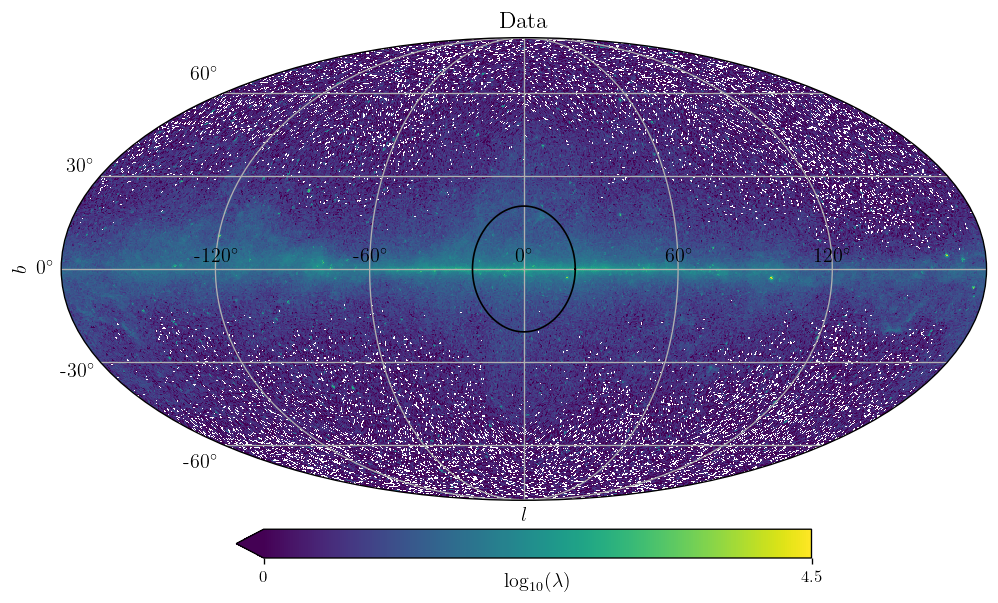

In [ ]:
# Top Plot: Data
fig = plt.figure(figsize=(12,6), dpi= 120)
eplt.allsky_map(m = np.log10(data), title = 'Data', vmin = 0, vmax = 4.5)
plt.savefig('figures/fig_allsky_data.svg', bbox_inches='tight')

/data/edr76/gce-gp/figures/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together with Fi

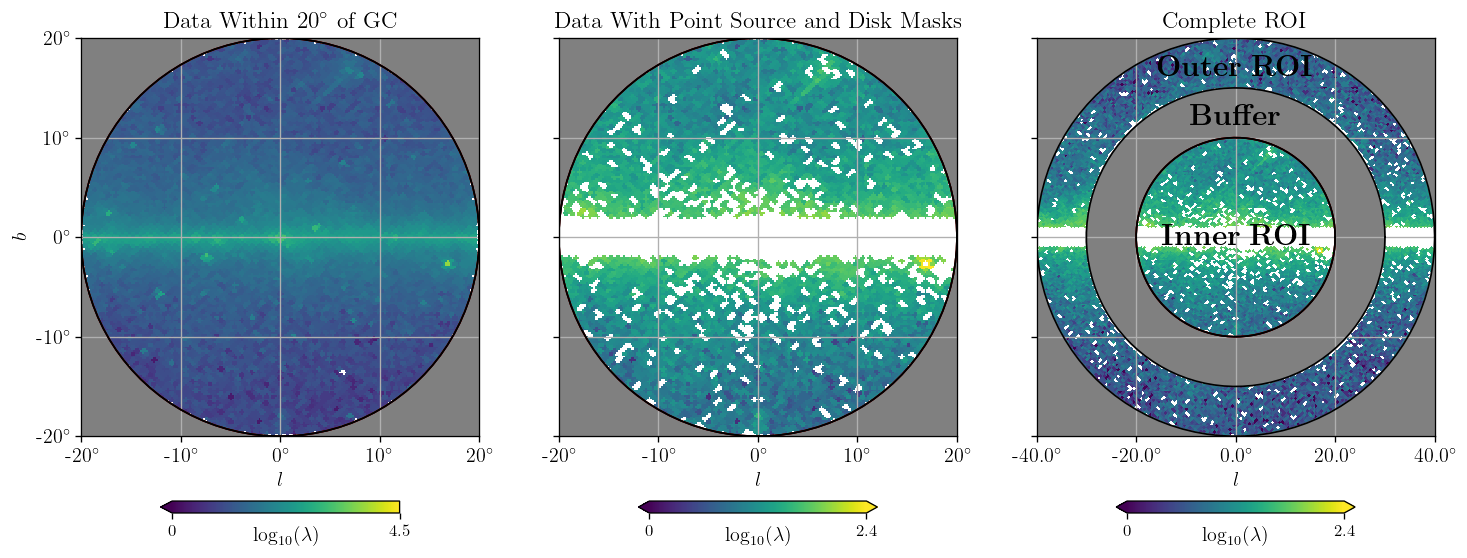

In [ ]:
# Bottom: Data Processing 
fig, axes = plt.subplots(figsize=(12, 6), dpi= 120, nrows = 1, ncols = 3) # DEFINING AXES FROM HERE DOES NOT WORK SEE SUBPLOT ARGUMENT BELOW

# Inner ROI, No Masking 
inner_mask = cm.make_mask_total(
        nside=nside,
        band_mask=False,
        mask_ring=True,
        inner=0,
        outer=20.,
    )
m = ef.convert_masked_array_to_hp_array(data[~inner_mask], inner_mask, log_option = True, nside=nside)
plt.axes(axes[0])
eplt.inner_roi_map(m, title = 'Data Within 20$^{\circ}$ of GC', vmin = 0, vmax = 4.5, subplot = 131)

# Inner ROI, w Masking
m = ef.convert_masked_array_to_hp_array(data[~mask_p], mask_p, log_option = True, nside=nside)
plt.axes(axes[1])
eplt.inner_roi_map(m, title = 'Data With Point Source and Disk Masks', vmin = 0, vmax = 2.4, subplot = 132, display_y_info = False)

# Complete ROI, w Masking
outer_mask = ebinmodel.outer_mask[ie]
total_mask = ~(~mask_p ^ ~outer_mask)
m = ef.convert_masked_array_to_hp_array(data[~total_mask], total_mask, log_option = True, nside=nside)
plt.axes(axes[2])
eplt.complete_roi_map(m, title = 'Complete ROI', vmin = 0, vmax = 2.4, subplot = 133, display_y_info = False)

plt.savefig('figures/fig_roi_steps.svg', bbox_inches='tight')

In [7]:
'''
Figure. Templates

purpose: Show a sample version of the templates./
'''


'\nFigure. Templates\n\npurpose: Show a sample version of the templates./\n'

In [8]:
# templates to build synthetic data (other option to do this below)
rig_temp_list = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_list = ['pib','ics', 'blg'] # pib, ics, blg
var_temp_list = ['nfw'] # nfw, dsk

ebinmodel = EbinPoissonModel(
        # important parameters
        is_gp = False,
        data_file = 'fermi_data_sum',

        # custom parameters
        rig_temp_list = rig_temp_list, # 'iso', 'psc', 'bub'
        hyb_temp_list = hyb_temp_list, # pib, ics, blg
        var_temp_list = var_temp_list, # nfw, dsk
        nfw_gamma = 1.2,
        blg_names = [ef.gen_blg_name_(i)[0] for i in range(5)],
        dif_names = ['czms-ch-'],
        )

nside = ebinmodel.nside
ebin = ie = ebinmodel.ebin
data = ebinmodel.counts[ie]
mask_p = ebinmodel.mask_roi_arr[ie]

In [9]:
from templates.variable_templates import NFWTemplate

mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 40.,
        inner = 0.,
    )

temp_iso = jnp.asarray(ebinmodel.temps['iso'].at_bin(ie, mask=mask))
temp_psc = jnp.asarray(ebinmodel.temps['psc'].at_bin(ie, mask=mask))
temp_bub = jnp.asarray(ebinmodel.temps['bub'].at_bin(ie, mask=mask))

temp_pib = jnp.squeeze(jnp.asarray([pib_temp.at_bin(ie, mask=mask) for pib_temp in ebinmodel.pib_temps]).T, 1)
temp_ics = jnp.squeeze(jnp.asarray([ics_temp.at_bin(ie, mask=mask) for ics_temp in ebinmodel.ics_temps]).T, 1)
temp_blg = jnp.asarray([blg_temp.at_bin(ie, mask=mask) for blg_temp in ebinmodel.blg_temps])

temp_nfw = jnp.asarray(ebinmodel.nfw_temp.get_NFW2_template(gamma=1.2))[~mask]

temp_dict = {
    'iso': temp_iso,
    'psc': temp_psc,
    'bub': temp_bub,
    'pib': temp_pib,
    'ics': temp_ics,
    'blg': temp_blg,
    'nfw': temp_nfw,
}
ordered_known_templates = ['iso', 'psc', 'bub', 'pib', 'ics']

/data/edr76/gce-gp/figures/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together with Fi

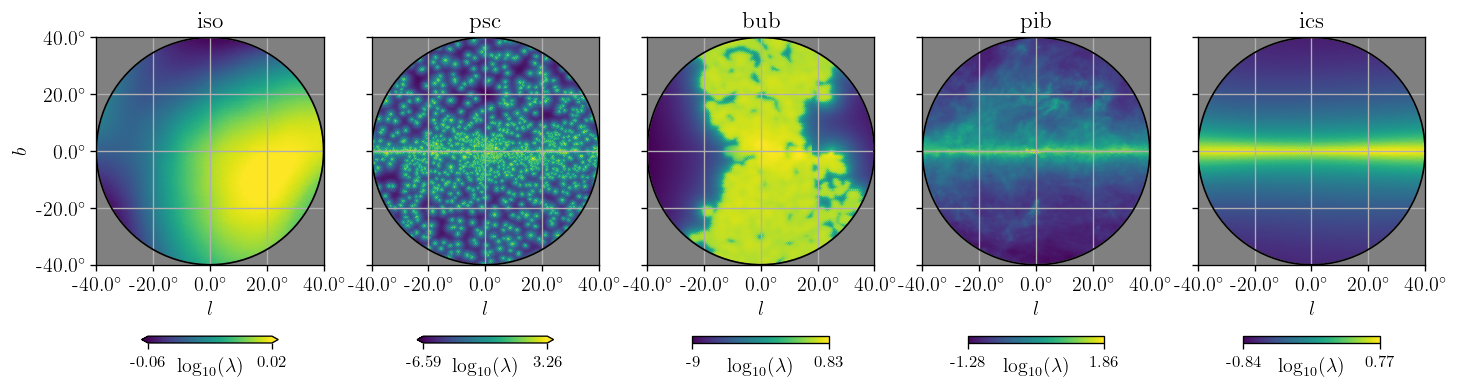

In [10]:
fig, axes = plt.subplots(figsize=(12, 6), dpi= 120, nrows = 1, ncols = 5) 
for n in range(len(ordered_known_templates)):
    name = ordered_known_templates[n]
    m = ef.convert_masked_array_to_hp_array(temp_dict[name], mask, log_option = True, nside = 128)
    plt.axes(axes[n])
    eplt.outer_roi_map(m, title = name, vmin = np.round(m.min(),2), vmax = np.round(m.max(),2), subplot = int(str(1) + str(5) + str(n + 1)), 
    display_y_info = False if n != 0 else True)
plt.tight_layout(pad = 0.1)
fig.savefig('figures/fig_templates_known.pdf', bbox_inches='tight')

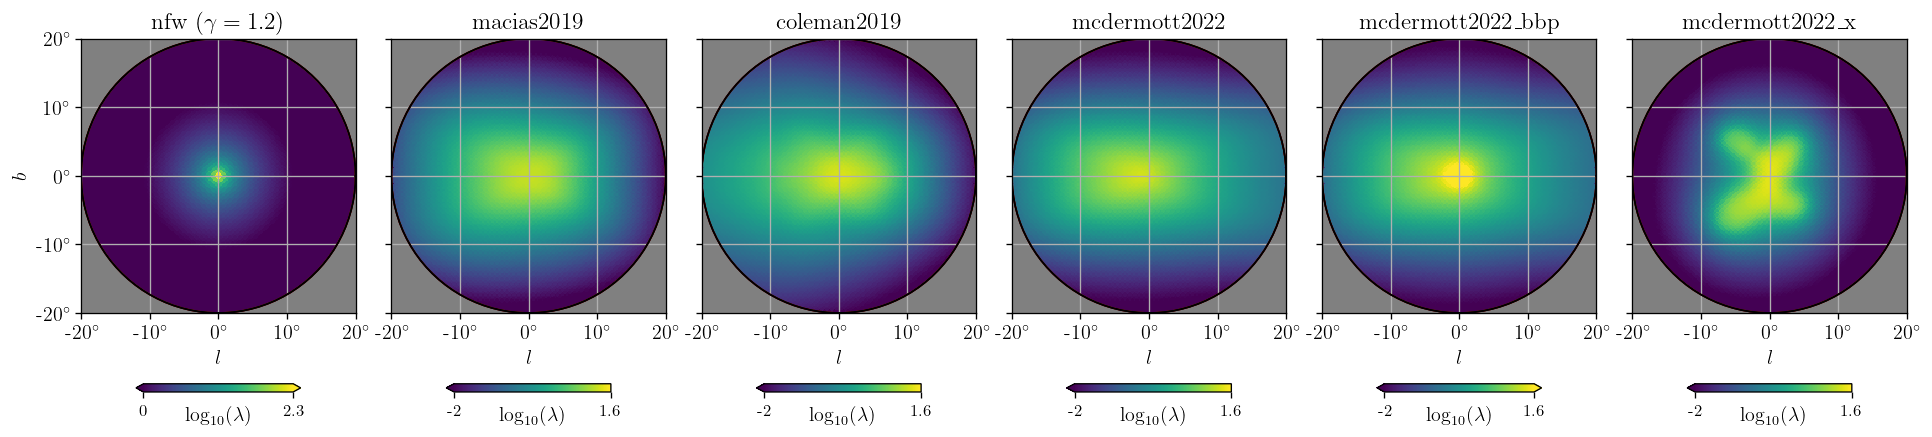

In [11]:
fig, axes = plt.subplots(figsize=(16, 6), dpi= 120, nrows = 1, ncols = 6) 

n = 0
m = ef.convert_masked_array_to_hp_array(temp_dict['nfw'], mask, log_option = True, nside = 128)
plt.axes(axes[0])
eplt.inner_roi_map(m, title = 'nfw ($\\gamma = 1.2$)', vmin = 0., vmax = 2.3, subplot = int(str(1) + str(6) + str(n + 1)), 
display_y_info = False if n != 0 else True)

for n in range(len(ebinmodel.blg_names)):
    name = ebinmodel.blg_names[n] 
    m = ef.convert_masked_array_to_hp_array(temp_dict['blg'][n], mask, log_option = True, nside = 128)
    plt.axes(axes[1 + n])
    eplt.inner_roi_map(m, title = name, vmin = -2., vmax = 1.6, subplot = int(str(1) + str(6) + str(n + 2)), 
    display_y_info = False)
plt.tight_layout(pad = 0.2)
fig.savefig('figures/fig_templates_gce.pdf', bbox_inches='tight')

In [12]:
'''
Figure 2. Corner plot and normalization histograms

source: notebooks/0a, 0b, 0c
'''

'\nFigure 2. Corner plot and normalization histograms\n\nsource: notebooks/0a, 0b, 0c\n'

In [3]:
# load GPU
gpu_id = '2'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# name of the synthetic directory
sim_name = 'canon_g1p2_ola'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 11
svi_id = 300 # (24,25) =  (no outer roi, outer roi)
sim_seed = 1000
svi_seed = 0

# load data directory
data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

0

In [4]:
# import all saved model parameters from python file
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    summary.txt
    __init__.py
    settings_7p1234567_5p23457_1p16_-1_11_300_1000_0.py
    ebin10_smp_svi_0.1_20000_mvn_8_1000_0.p
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_11_300_1000_0.cpython-311.pyc


In [5]:
# load model using stored parameters
ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )
ebinmodel.config_model(ebin=ebin)

In [6]:
# load saved data from GP -> Data fit
fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

samples_dict, svi_results = pickle.load(open(fit_dir + fit_file_name, 'rb'))

# generate temp_sample_dict
all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'nfw', 'dsk', 'gp']
names = list(samples_dict.keys())
temp_sample_dict = {k: samples_dict[k] for k in all_temp_names if k in names}
temp_sample_dict_cmask = {k: samples_dict[k + '_cmask'] for k in all_temp_names if k in names}

In [7]:
# load true data if exits
if data_file != 'fermi_data_sum':
    temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
else:
    pass

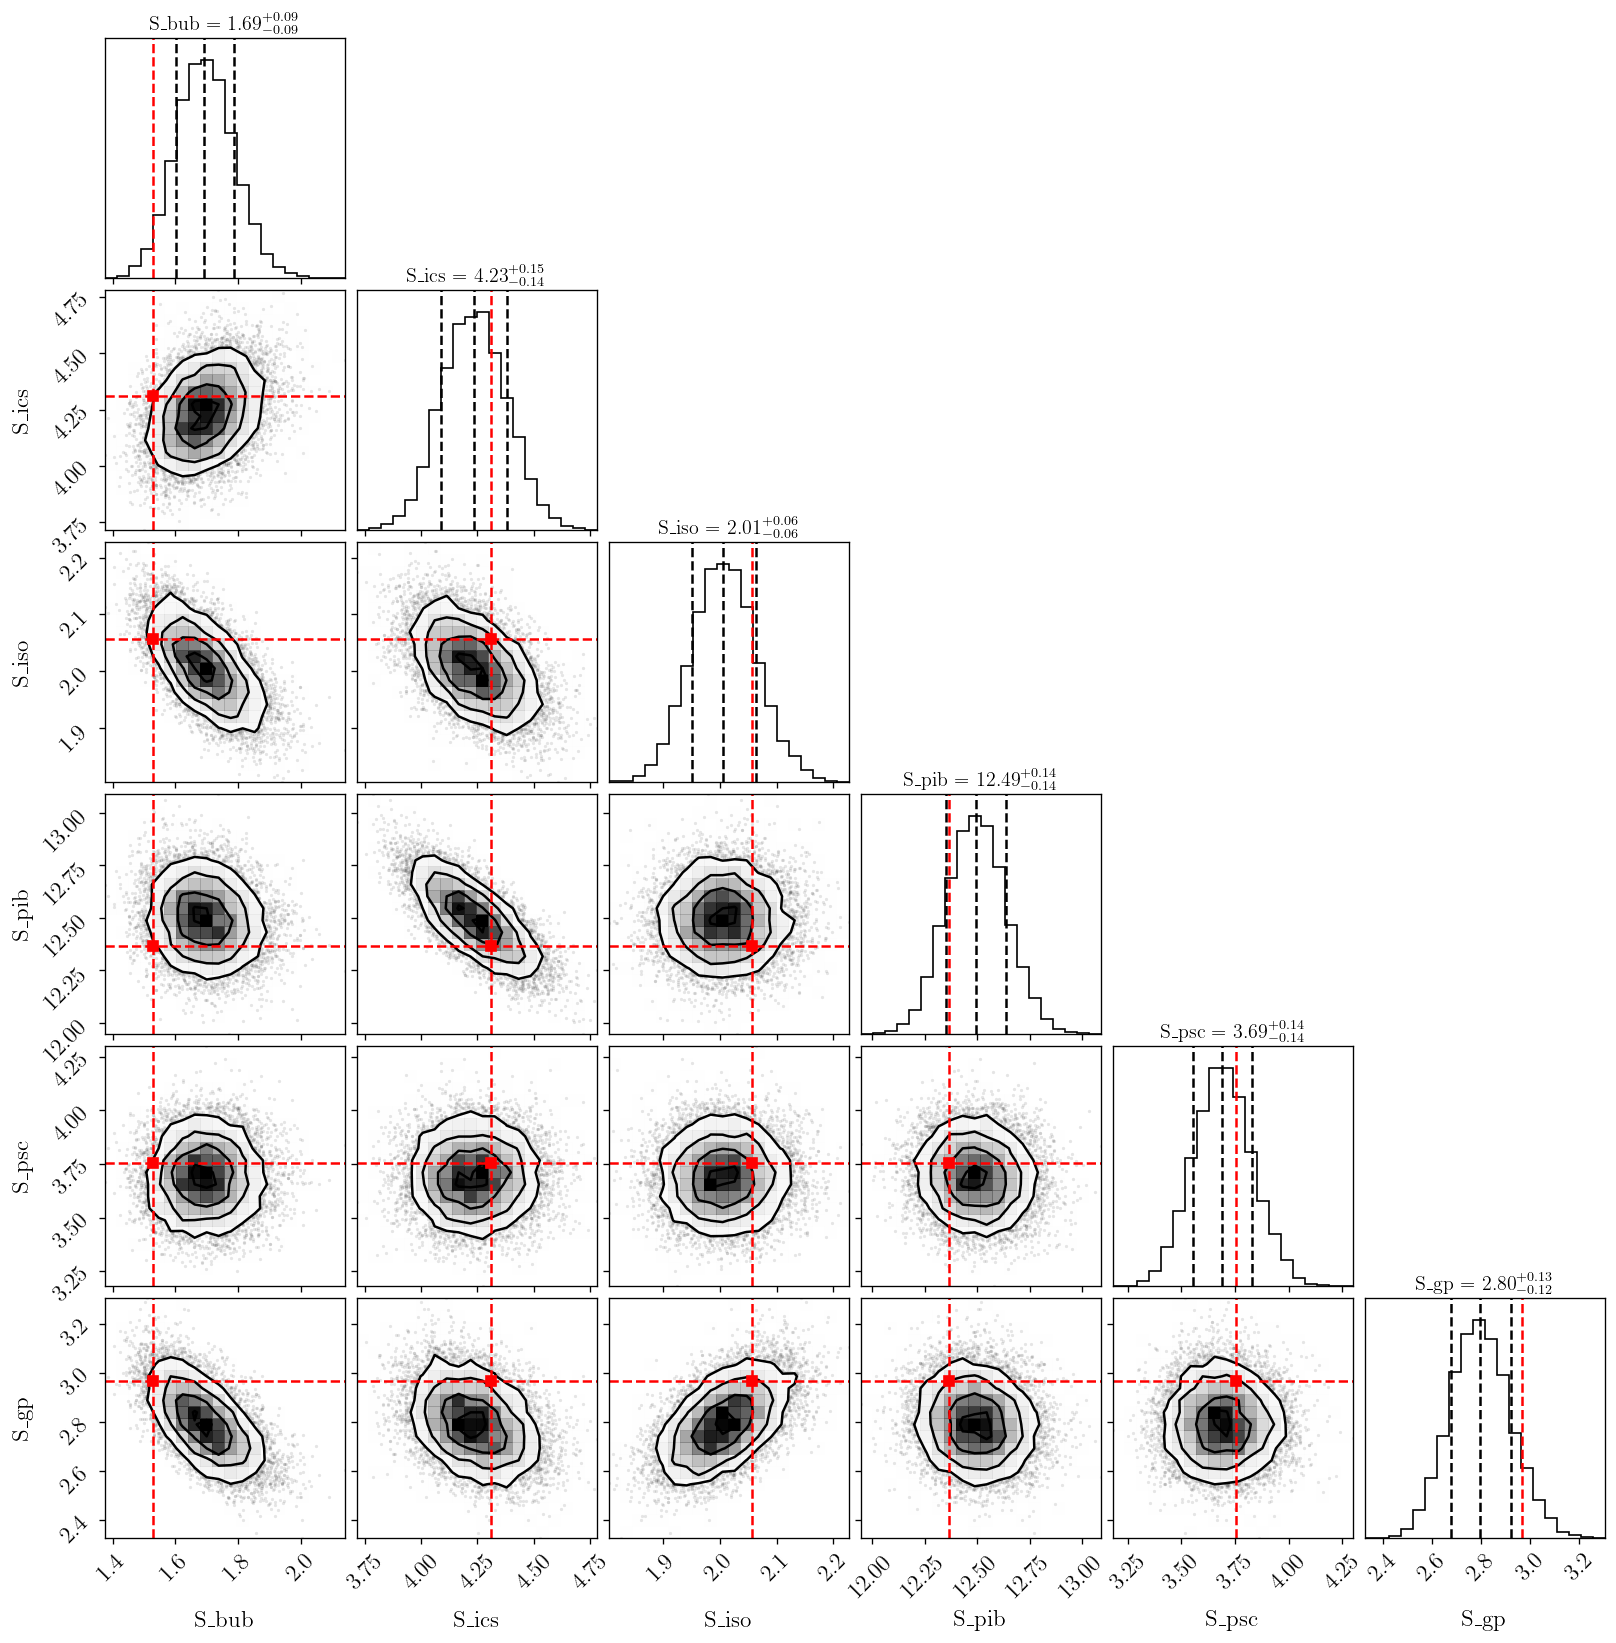

In [18]:
# generate corner plots
corner_keys = [k for k in list(samples_dict.keys()) if 'S_' in k]
corner_samples = {k : samples_dict[k] for k in corner_keys}

if data_file != 'fermi_data_sum':
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)
else:
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = False, temp_dict = None)
fig.savefig('figures/fig_sim_corner_plot.svg', bbox_inches='tight')

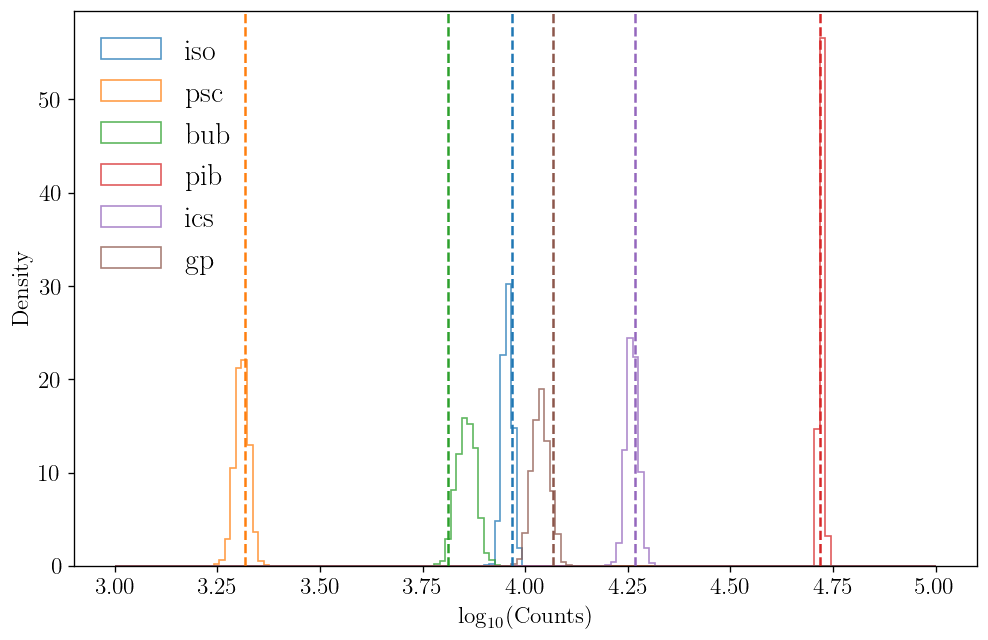

In [19]:
# generate samples and plot histograms of log counts
mask_p = ebinmodel.mask_roi_arr[ebin]
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

fig = plt.figure(figsize=(6 * 1.618, 6), dpi= 120)
ax = fig.add_subplot(111)

if data_file != 'fermi_data_sum':
    ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = ax)
else:
    ef.tot_log_counts_hist(temp_sample_dict, None, None, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = ax)
fig.savefig('figures/fig_sim_log_counts_hist.svg', bbox_inches='tight')

/data/edr76/gce-gp/figures/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(custom_xtick_labels, fontname=fontname)
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:630: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.yaxis.set_ticklabels(custom_ytick_labels, fontname=fontname)


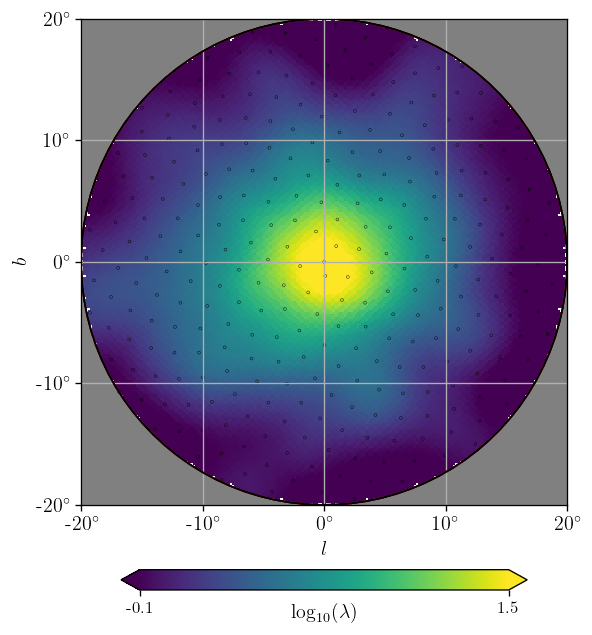

In [8]:
# Bottom: Data Processing 
fig, ax = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1) # DEFINING AXES FROM HERE DOES NOT WORK SEE SUBPLOT ARGUMENT BELOW

mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )
q = np.percentile(temp_sample_dict_cmask['gp'], 50, axis = 0)
m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
plt.axes(ax)
eplt.inner_roi_map(m, title = None, vmin = -0.1, vmax = 1.5, subplot = 111)

xu_f = ebinmodel.xu_f
xu_f_r = np.deg2rad(xu_f)
plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

In [9]:
# # 1d slices
# # load cartesian grid
# n_pixels = 40 # set to 40 if too slow
# Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = n_pixels)

# cartesian map of masks to keep track of masking for plots
mask_map = np.zeros((~ebinmodel.mask_roi_arr[ebin]).sum())
mask_map_cart = ef.healpix_to_cart(mask_map, ebinmodel.mask_roi_arr[ebin], n_pixels = n_pixels, nside = 128, nan_fill = True) # doesn't matter what mask used

# cartesian gp samples
exp_gp_samples = temp_sample_dict_cmask['gp']
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels = n_pixels, nside = 128)

# create gp_true from scratch
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
ebinmodel.load_templates(temp_names_sim, blg_names, dif_names)
gp_true = ( temp_dict['S_blg'] * ebinmodel.blg_temps[0].at_bin(ebin, mask) + temp_dict['S_nfw'] * ebinmodel.nfw_temp.get_NFW2_template(gamma = temp_dict['gamma'])[~mask] )

# 1D slice of total rate
tot_samples = jnp.zeros(np.sum(~mask))
tot_names = list(temp_sample_dict_cmask.keys())
for tot_name in tot_names:
    tot_samples += temp_sample_dict_cmask[tot_name]
tot_samples_cart = ef.multi_healpix_to_cart(tot_samples, mask, n_pixels = n_pixels, nside = 128)

sim_samples = jnp.zeros(np.sum(~mask))
for sim_name in temp_names_sim:
    sim_samples += temp_dict[sim_name][~mask]

# 1D slice of residual posterior rate samples relative to truth
model_residuals = tot_samples - sim_samples
model_residuals_cart = ef.multi_healpix_to_cart(model_residuals, mask, n_pixels=n_pixels, nside = 128)

# 1D slice of residual data relative to posterior samples
rng_key = jax.random.PRNGKey(53)
rng_key, key = jax.random.split(rng_key)
poisson_samples = jax.random.poisson(key, tot_samples)
data_residuals = ebinmodel.counts[ebin][~mask] - poisson_samples
data_residuals_cart = ef.multi_healpix_to_cart(data_residuals, mask, n_pixels = n_pixels, nside = 128)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 374.59it/s]


Slice at y = 6.00000 deg


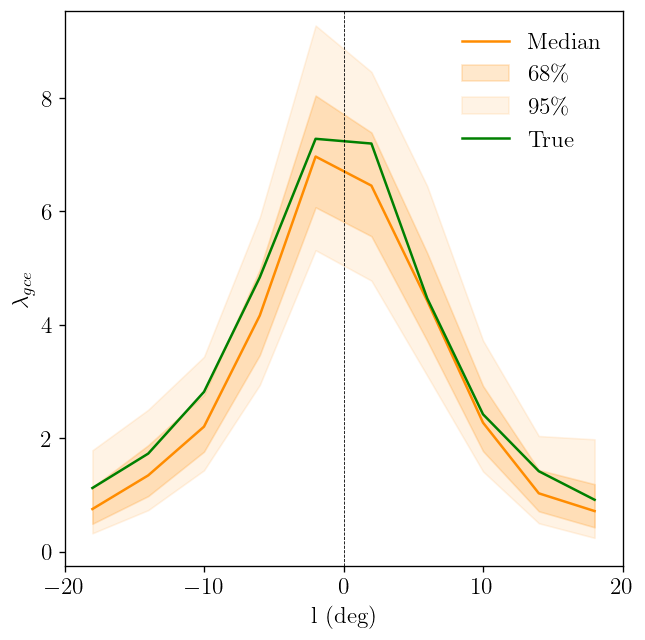

In [10]:
fig, axes = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1)
slice_val = 3.2
# 1d slice of GCE
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0) # cartesian sample map quantiles
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels = n_pixels, nside = 128) # simulated rate cartesian map
raw_cart = None

plt.axes(axes)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')
fig.savefig('figures/fig_sim_gp_slice.svg', bbox_inches='tight')

Slice at x = 3.37500 deg


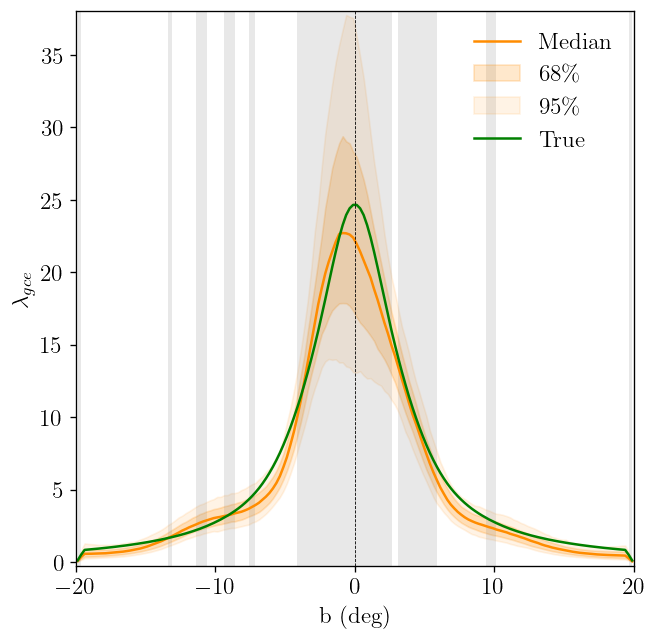

In [29]:
fig, axes = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1)
slice_val = 3.2
# 1d slice of GCE
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0) # cartesian sample map quantiles
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels = n_pixels, nside = 128) # simulated rate cartesian map
raw_cart = None

plt.axes(axes)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'vertical', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')
fig.savefig('figures/fig_sim_gp_slice.svg', bbox_inches='tight')

Slice at y = 3.37500 deg
Slice at y = 3.37500 deg


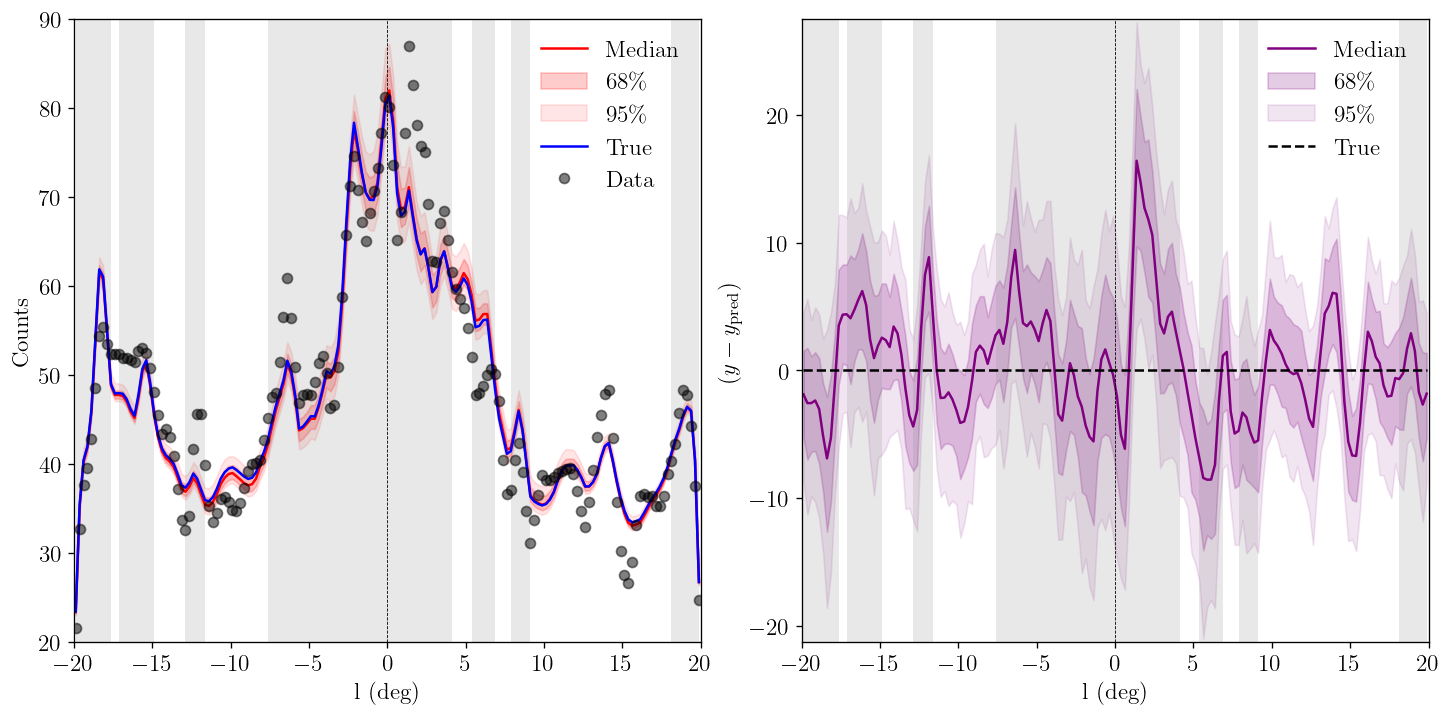

In [30]:
slice_val = 3.2  # y-value of slice

fig, axes = plt.subplots(figsize=(12, 6 - 0.125), dpi= 120, nrows = 1, ncols = 2)

# 1d slice of total rate map
q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels = n_pixels, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

plt.axes(axes[0])
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_val = slice_val, 
    ylim = [20., 90.],
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,)

# 1d slice of total rate residuals
q = np.percentile(data_residuals_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = np.zeros((n_pixels,n_pixels))
raw_cart = None

plt.axes(axes[1])
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$(y - y_\mathrm{pred})$', q_color = 'purple', line_color = 'k', ls = '--')

fig.tight_layout(pad = 0.2)
# fig.savefig('figures/fig_sim_tot_slice.pdf', bbox_inches='tight')

Slice at y = 3.12500 deg
Slice at y = 3.12500 deg
Slice at x = 3.12500 deg
Slice at x = 3.12500 deg


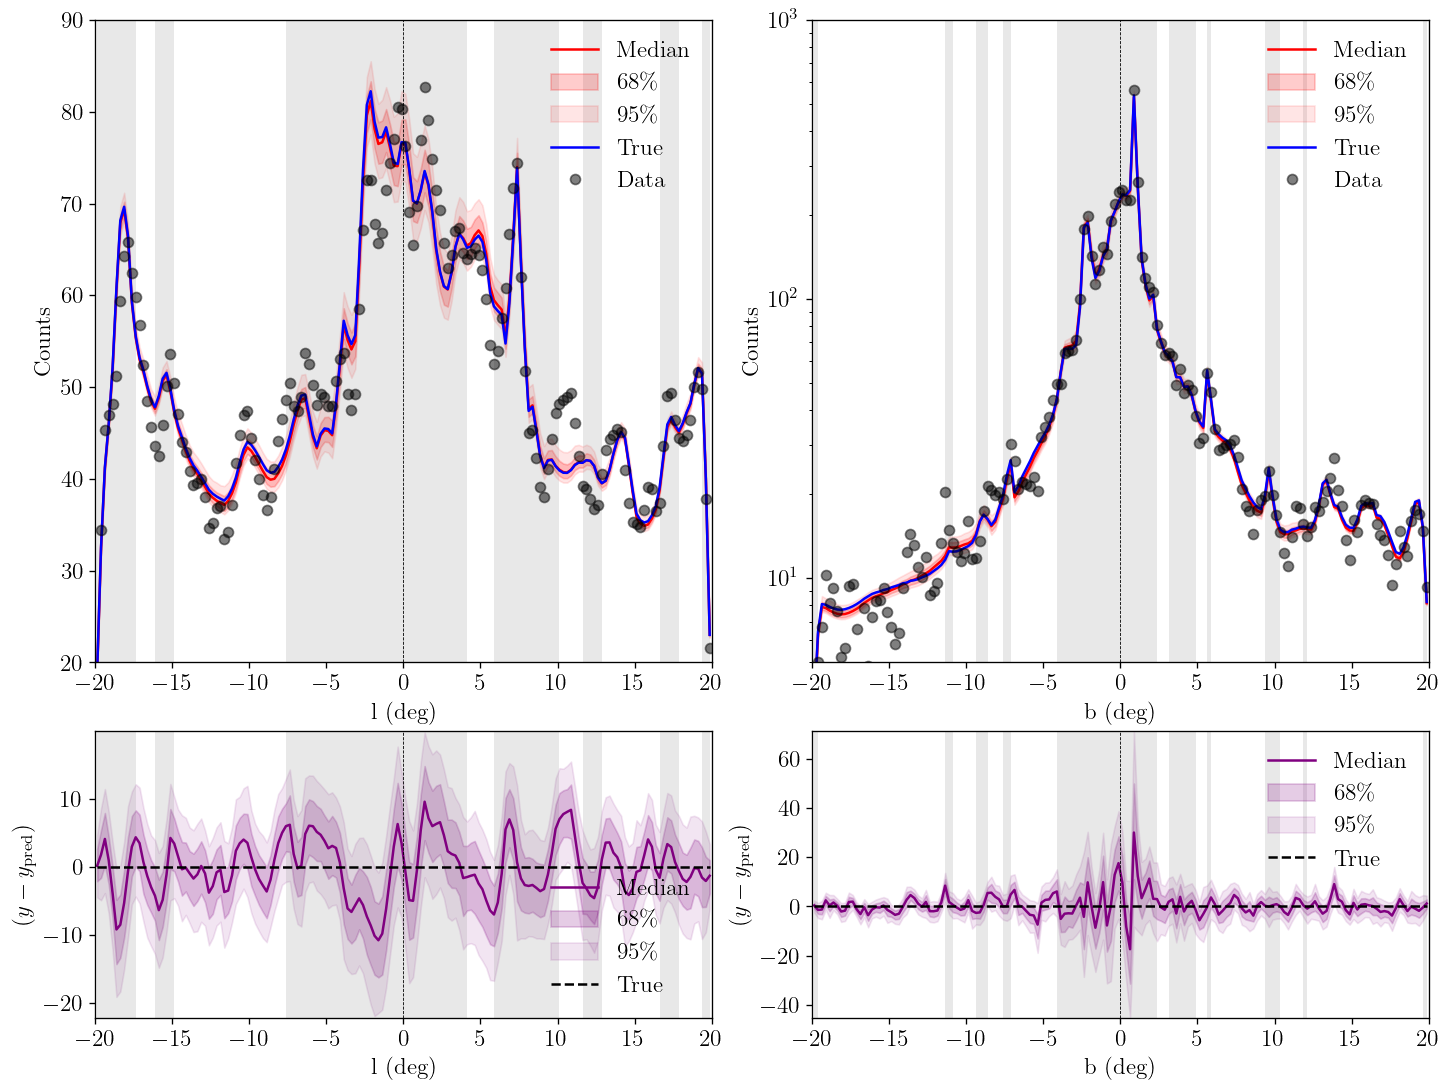

In [17]:
slice_val = 3.  # y-value of slice

fig = plt.figure(figsize=(12,9), dpi= 120)

ax11 = plt.subplot2grid((3, 4), (0, 0), rowspan = 2, colspan = 2)
ax21 = plt.subplot2grid((3, 4), (2, 0), rowspan = 1, colspan = 2)
ax12 = plt.subplot2grid((3, 4), (0, 2), rowspan = 2, colspan = 2)
ax22 = plt.subplot2grid((3, 4), (2, 2), rowspan = 1, colspan = 2)

# 1d slice of total rate map
q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels = n_pixels, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

plt.axes(ax11)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'horizontal', slice_val = slice_val, 
    ylim = [20., 90.],
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,)

# 1d slice of total rate residuals
q = np.percentile(data_residuals_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = np.zeros((n_pixels,n_pixels))
raw_cart = None

plt.axes(ax21)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'horizontal', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$(y - y_\mathrm{pred})$', q_color = 'purple', line_color = 'k', ls = '--')

# 1d slice of total rate map
q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels = n_pixels, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

plt.axes(ax12)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'vertical', slice_val = slice_val, 
    ylim = [5., 1000.], yscale = 'log',
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,)

# 1d slice of total rate residuals
q = np.percentile(data_residuals_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = np.zeros((n_pixels,n_pixels))
raw_cart = None

plt.axes(ax22)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'vertical', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$(y - y_\mathrm{pred})$', q_color = 'purple', line_color = 'k', ls = '--')

fig.tight_layout(pad = 0.2)
# fig.savefig('figures/fig_sim_tot_slice.pdf', bbox_inches='tight')
# fig.savefig('figures/fig_sim_tot_slice.pdf', bbox_inches='tight')

Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg


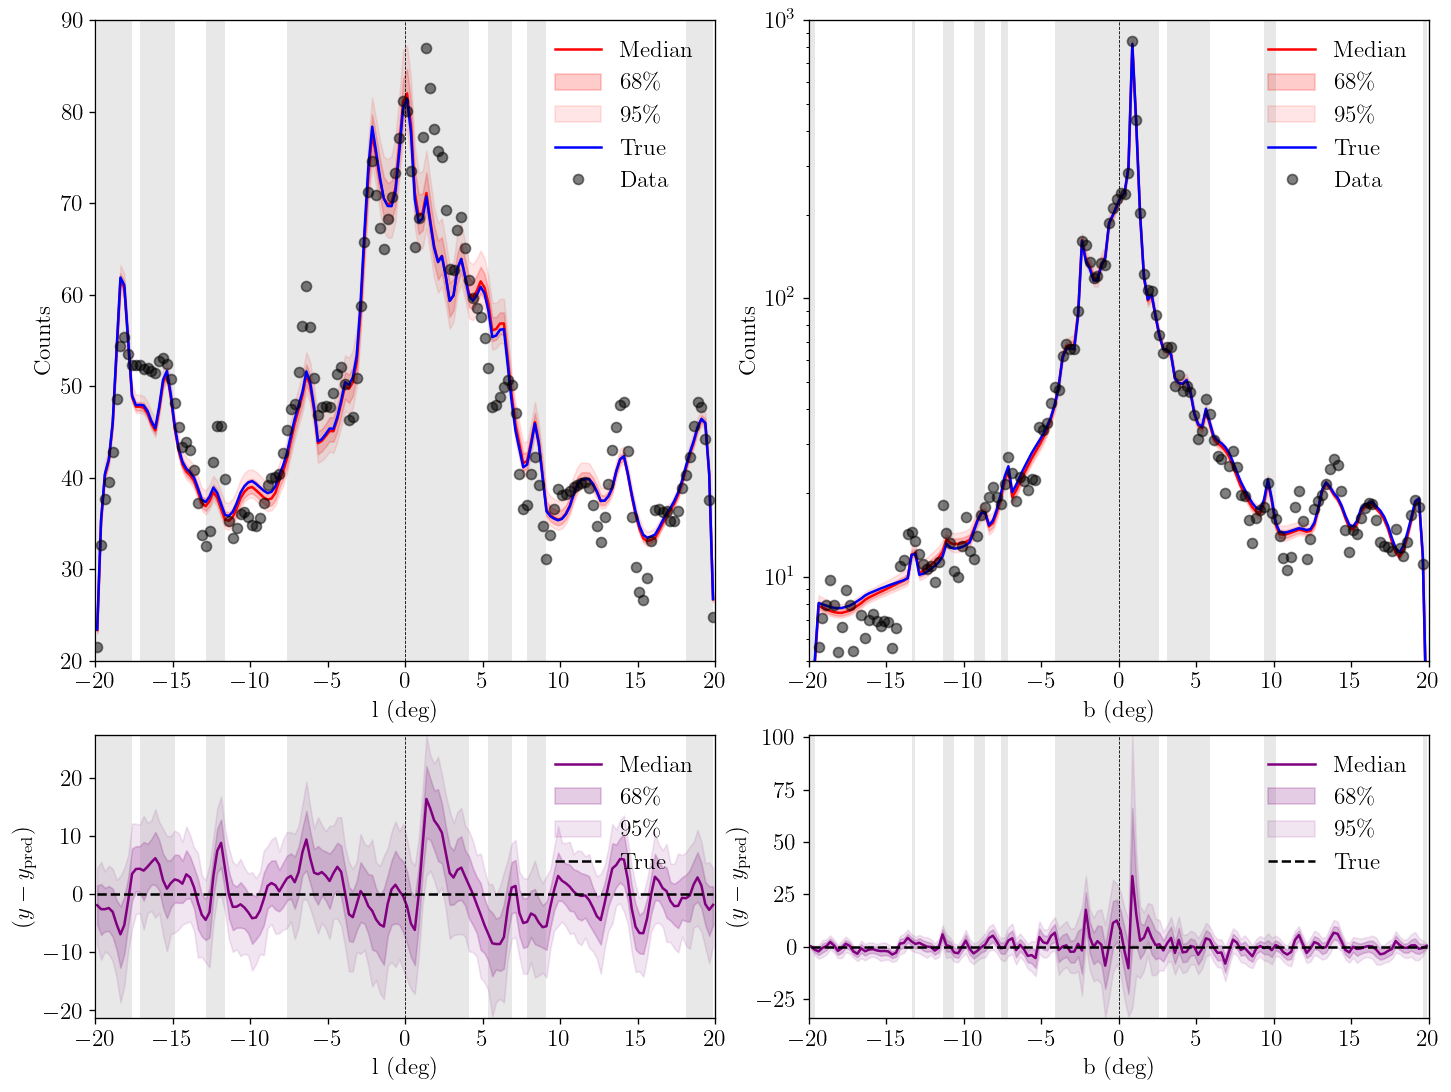

In [33]:
slice_val = 3.2  # y-value of slice

fig = plt.figure(figsize=(12,9), dpi= 120)

ax11 = plt.subplot2grid((3, 4), (0, 0), rowspan = 2, colspan = 2)
ax21 = plt.subplot2grid((3, 4), (2, 0), rowspan = 1, colspan = 2)
ax12 = plt.subplot2grid((3, 4), (0, 2), rowspan = 2, colspan = 2)
ax22 = plt.subplot2grid((3, 4), (2, 2), rowspan = 1, colspan = 2)

# 1d slice of total rate map
q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels = n_pixels, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

plt.axes(ax11)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'horizontal', slice_val = slice_val, 
    ylim = [20., 90.],
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,)

# 1d slice of total rate residuals
q = np.percentile(data_residuals_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = np.zeros((n_pixels,n_pixels))
raw_cart = None

plt.axes(ax21)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'horizontal', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$(y - y_\mathrm{pred})$', q_color = 'purple', line_color = 'k', ls = '--')

# 1d slice of total rate map
q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels = n_pixels, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

plt.axes(ax12)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'vertical', slice_val = slice_val, 
    ylim = [5., 1000.], yscale = 'log',
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,)

# 1d slice of total rate residuals
q = np.percentile(data_residuals_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = np.zeros((n_pixels,n_pixels))
raw_cart = None

plt.axes(ax22)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'vertical', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$(y - y_\mathrm{pred})$', q_color = 'purple', line_color = 'k', ls = '--')

fig.tight_layout(pad = 0.2)
# fig.savefig('figures/fig_sim_tot_slice.pdf', bbox_inches='tight')
# fig.savefig('figures/fig_sim_tot_slice.pdf', bbox_inches='tight')

Slice at y = 3.37500 deg
Slice at x = 3.37500 deg


/data/edr76/gce-gp/figures/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: set_ticklabels() should only be used with a fixed n

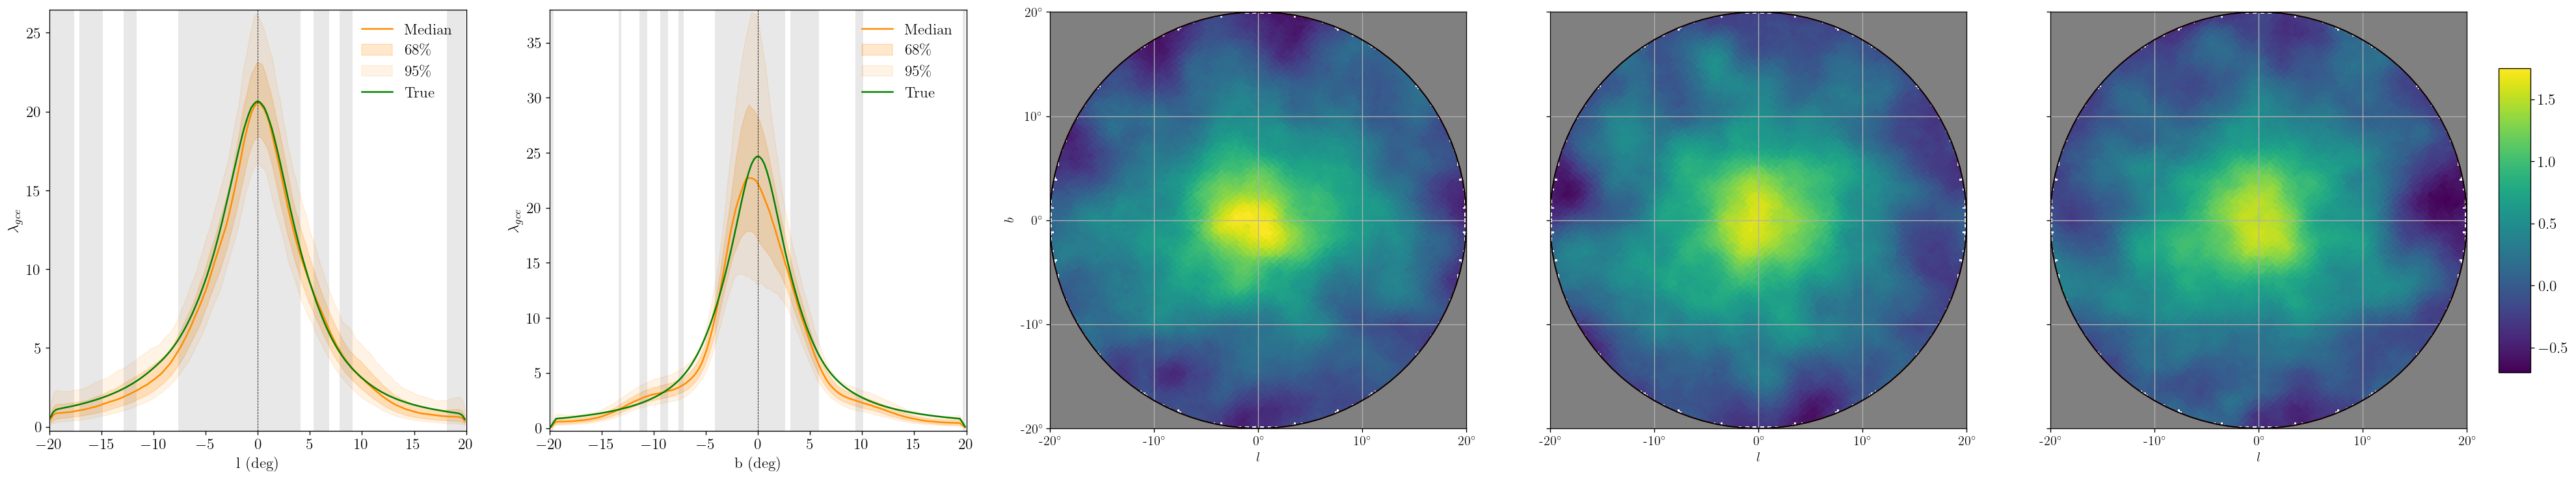

In [34]:
slice_val = 3.2  # y-value of slice

n_subplots = 5 
vmin = -0.7 ; vmax = 1.75

# gridspec = {'width_ratios': [1, 1, 1, 1, 1, 0.1]}
fig, axes = plt.subplots(figsize=(8.15*n_subplots, 6), dpi= 120, nrows = 1, ncols = n_subplots)

# 1d slice of GCE
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0) # cartesian sample map quantiles
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels = n_pixels, nside = 128) # simulated rate cartesian map
raw_cart = None

plt.axes(axes[0], aspect = 'equal')
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'horizontal', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')

plt.axes(axes[1], aspect = 'equal')
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_dir = 'vertical', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')

for n in range(2, n_subplots):
    m = ef.convert_masked_array_to_hp_array(temp_sample_dict_cmask['gp'][n], mask, log_option = True, nside = 128)
    ax = axes[n]
    plt.axes(ax)
    eplt.inner_roi_map(m, title = None, vmin = vmin, vmax = vmax, subplot = int('1' + str(n_subplots) + str(n + 1)), 
        display_y_info = False if n != 2 else True,
        cbar = False, 
        xsize = xsize)
    
# setup the normalization and the colormap
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
colormap = mpl.cm.viridis

# setup the colorbar
scalarmappaple = mpl.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(np.linspace(vmin,vmax,100))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.175, 0.01, 0.65])  # left, bottom, width, height
# plt.tight_layout(pad = -2)
fig.colorbar(scalarmappaple, cax=cbar_ax)
fig.savefig('figures/fig_sim_gp_samples.pdf', bbox_inches='tight')

In [12]:
'''
Figure 3. Fits to Real Data

source: notebooks/1a, 1b, 1c
'''

'\nFigure 3. Fits to Real Data\n\nsource: notebooks/1a, 1b, 1c\n'

In [35]:
# load GPU
gpu_id = '2'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# name of the synthetic directory
sim_name = 'fit_to_data'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 10000
svi_id = 42 # (24,25) =  (no outer roi, outer roi)
sim_seed = -1
svi_seed = 0

# load data directory
data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)
# import all saved model parameters from python file
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_2.p
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_1.p
    settings_7p1234567_5p23457_1p16_-1_10000_42_-1_0.py
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_1.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_0.p
    summary.txt
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_2.p
    __init__.py
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_10000_42_-1_0.cpython-311.pyc


In [36]:
# load saved data from GP -> Data fit
fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

samples_dict, svi_results = pickle.load(open(fit_dir + fit_file_name, 'rb'))

# generate temp_sample_dict
all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'nfw', 'dsk', 'gp']
names = list(samples_dict.keys())
temp_sample_dict = {k: samples_dict[k] for k in all_temp_names if k in names}
temp_sample_dict_cmask = {k: samples_dict[k + '_cmask'] for k in all_temp_names if k in names}

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_1p16_-1_10000_42_-1_0 not in sys.modules
]


In [37]:
# load all model fits
mod_ids = [11, 10000, 20000, 30000, 40000, 50000]
samples_dict_list = [] ; svi_results_list = []
temp_sample_dict_list = [] ; temp_sample_dict_cmask_list = []
temp_samples_list = [] ; temp_svi_results_list = []
for mod_id in mod_ids:
    fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
    fit_dir = data_dir + 'fits/' + fit_filename + '/'
    ef.list_files(fit_dir)

    sys.path.append(fit_dir)
    import importlib 
    module = importlib.import_module(module_name)

    # Load all the variables from the module
    globals().update(vars(module))

    # load saved data from GP -> Data fit
    fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
                str_lr + '_' + str_n_steps + '_' + 
                    str_guide + '_' + str_num_particles + '_' + 
                    str_sim_seed + '_' + str_svi_seed + '.p')

    samples_dict, svi_results = pickle.load(open(fit_dir + fit_file_name, 'rb'))
    samples_dict_list.append(samples_dict) ; svi_results_list.append(svi_results)

    # generate temp_sample_dict
    all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'nfw', 'dsk', 'gp']
    names = list(samples_dict.keys())
    temp_sample_dict = {k: samples_dict[k] for k in all_temp_names if k in names}
    temp_sample_dict_cmask = {k: samples_dict[k + '_cmask'] for k in all_temp_names if k in names}
    temp_sample_dict_list.append(temp_sample_dict) ; temp_sample_dict_cmask_list.append(temp_sample_dict_cmask)

    # load 
    ebin = 10
    str_ebin = str(ebin)

    guide = 'mvn'
    str_guide = guide

    n_steps_t = 15000
    str_n_steps_t = str(n_steps_t)

    lr_t = 0.02  
    str_lr_t = str(lr_t)   # BE SURE TO CHANGE THIS

    num_particles_t = 8
    str_num_particles_t = str(num_particles_t)

    svi_seed_t = 0
    str_svi_seed_t = str(svi_seed_t)

    # need to add gp2temp information for fit
    temp_fit_file_name = ('gp2temp_allblgs' + 'ebin' + str_ebin + '_smp_svi_' + 
            str_lr_t + '_' + str_n_steps_t + '_' + 
            str_guide + '_' + str_num_particles_t + '_' + 
            str_sim_seed + '_' + str_svi_seed_t + '.p')
    temp_samples, temp_svi_results = pickle.load(open(fit_dir + temp_fit_file_name, 'rb'))
    temp_samples_list.append(temp_samples) ; temp_svi_results_list.append(temp_svi_results)

/
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
    settings_7p1234567_5p23457_1p16_-1_11_42_-1_0.py
    __init__.py
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_0.p
    summary.txt
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_11_42_-1_0.cpython-311.pyc
/
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_2.p
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_1.p
    settings_7p1234567_5p23457_1p16_-1_10000_42_-1_0.py
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_1.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_0.p
    summary.txt
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_2.p
    __init__.py
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_10000_42_-1_0.cpython-311.pyc
/
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
    gp2temp_

In [38]:
# obtain 1d slice plots for all models
tot_samples_cart_list = []
model_residuals_cart_list = []
for i in range(6):
    temp_sample_dict_cmask = temp_sample_dict_cmask_list[i]

    # 1D slice of total rate
    tot_samples = jnp.zeros(np.sum(~mask))
    tot_names = list(temp_sample_dict_cmask.keys())
    for tot_name in tot_names:
        tot_samples += temp_sample_dict_cmask[tot_name]
    tot_samples_cart = ef.multi_healpix_to_cart(tot_samples, mask, n_pixels = n_pixels, nside = 128)

    # 1D slice of residual data relative to posterior samples
    rng_key = jax.random.PRNGKey(53)
    rng_key, key = jax.random.split(rng_key)
    poisson_samples = jax.random.poisson(key, tot_samples)
    data_residuals = ebinmodel.counts[ebin][~mask] - poisson_samples
    data_residuals_cart = ef.multi_healpix_to_cart(data_residuals, mask, n_pixels = n_pixels, nside = 128)

    tot_samples_cart_list.append(tot_samples_cart)
    model_residuals_cart_list.append(data_residuals_cart)
    
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_1p16_-1_50000_42_-1_0 not in sys.modules
]
100%|██████████| 1000/1000 [00:25<00:00, 39.79it/s]


Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg


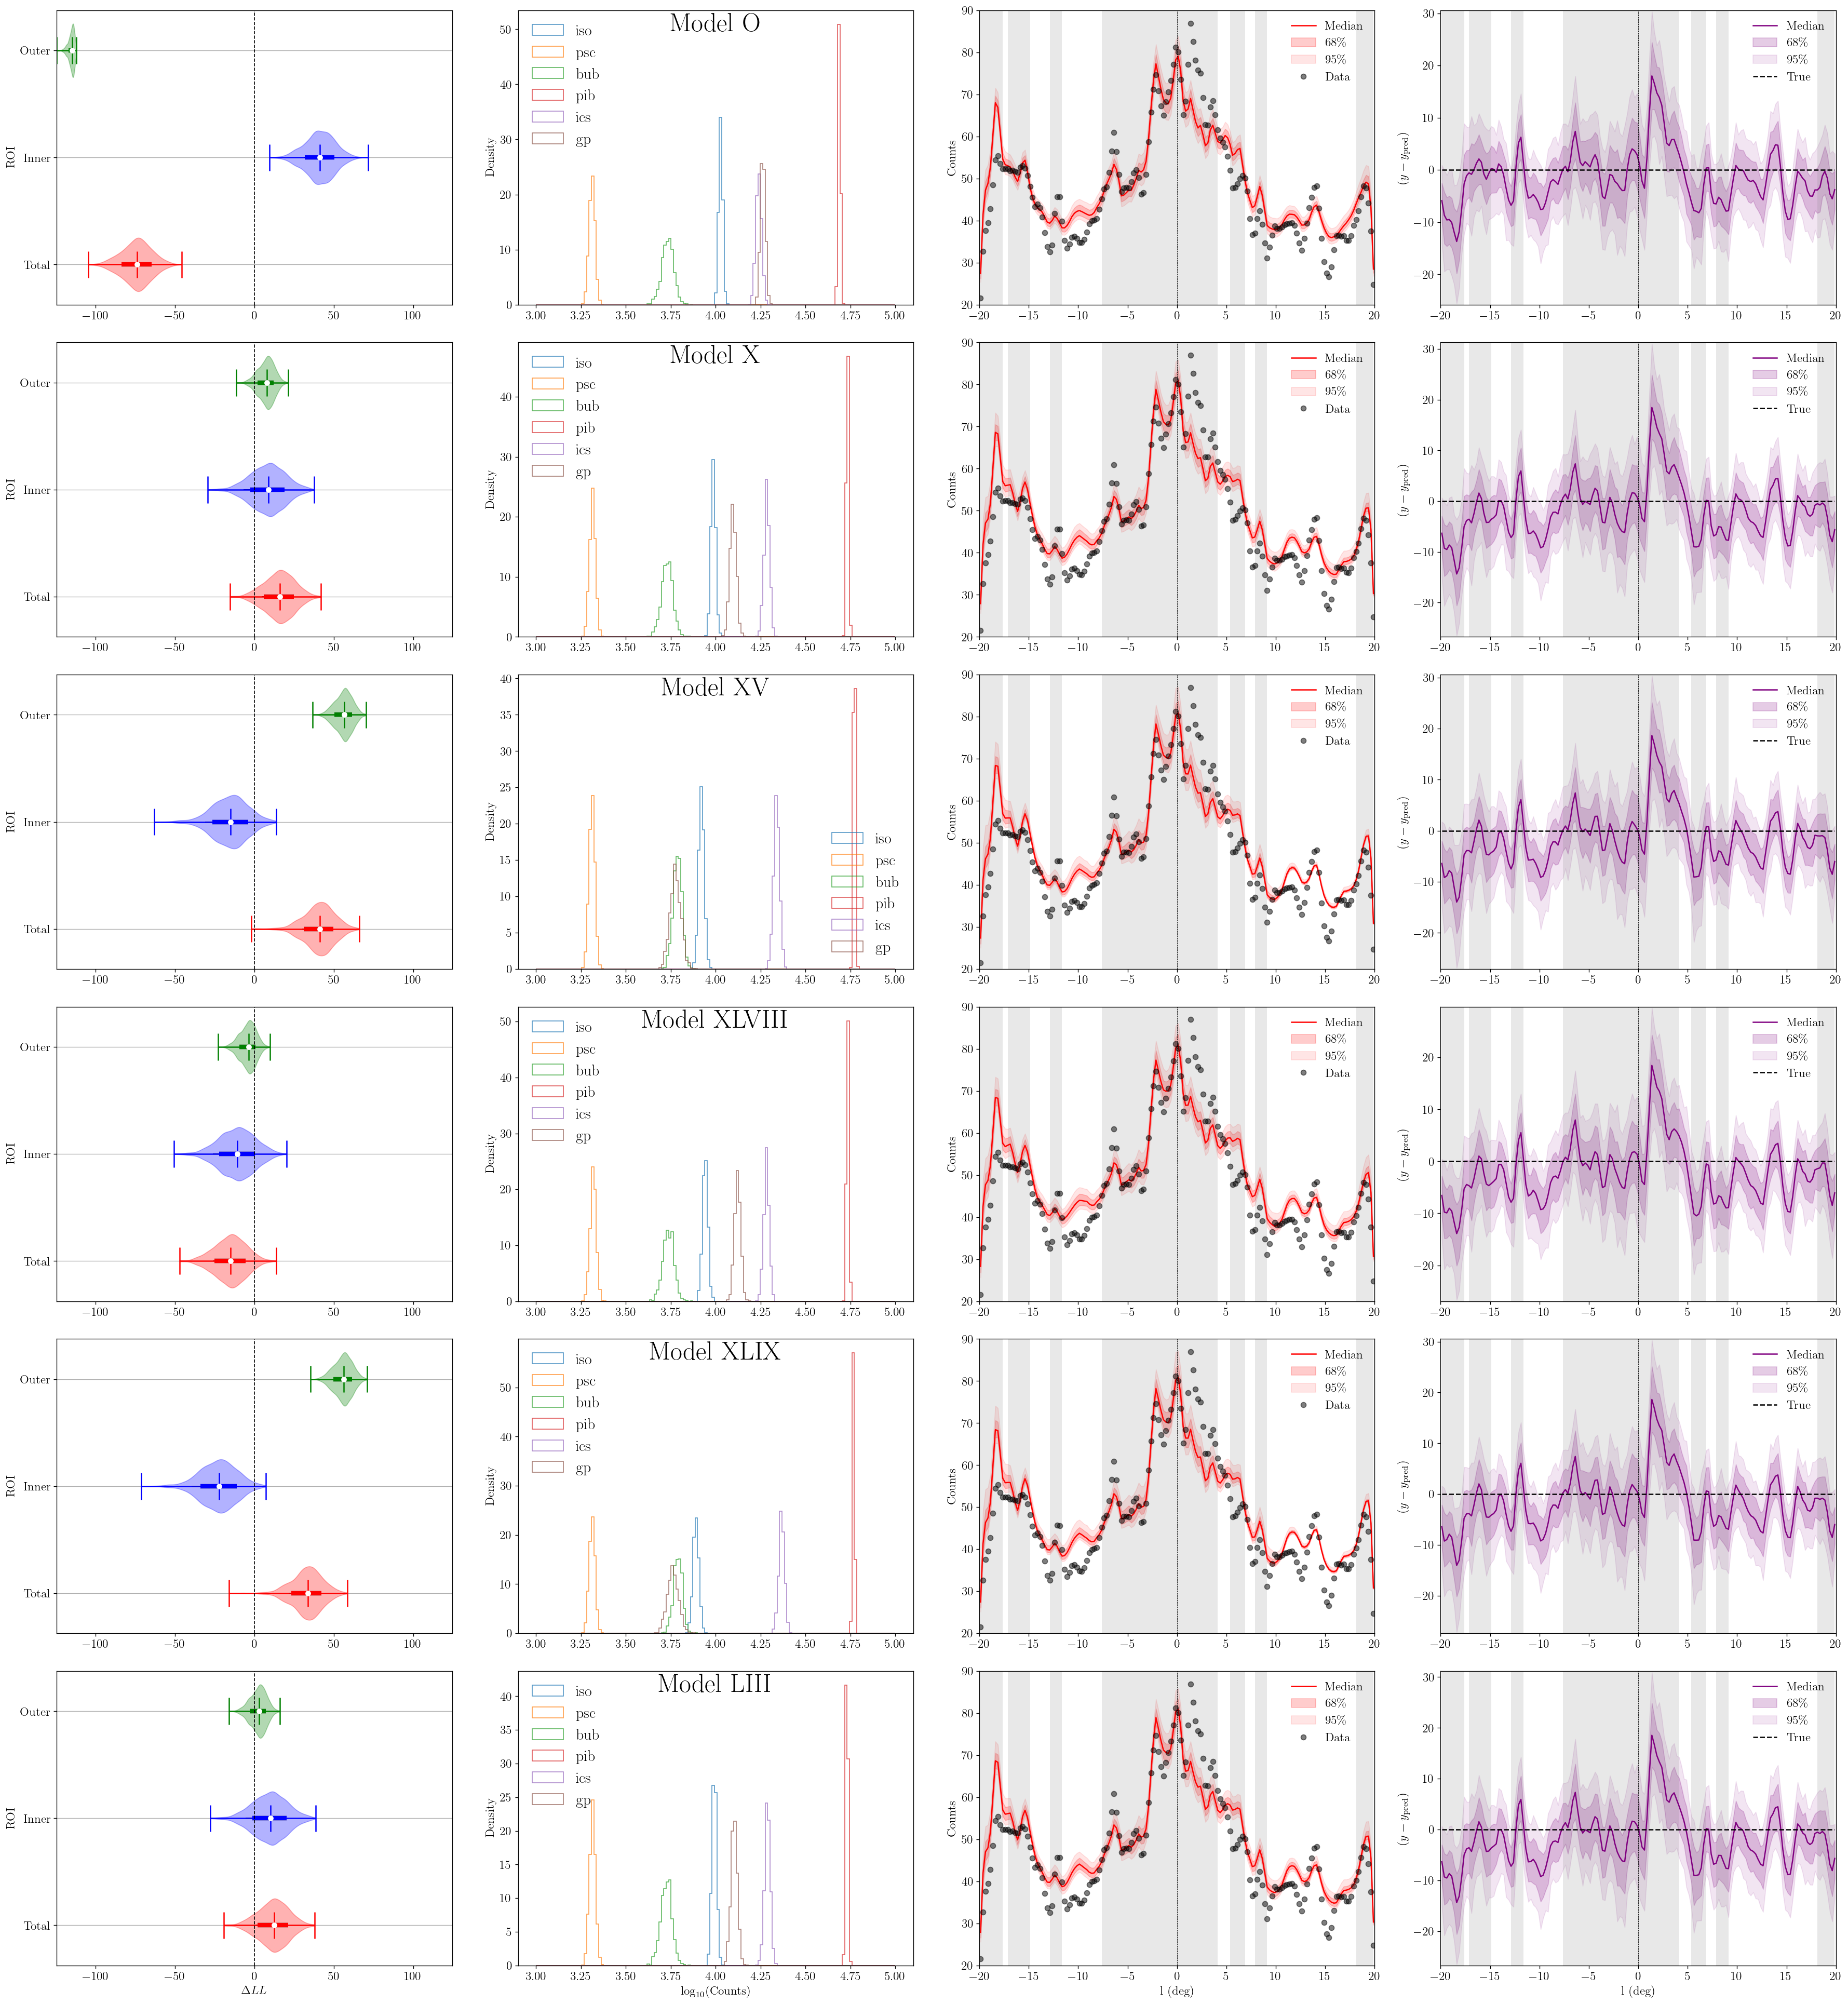

In [39]:
nrows = 6 ; ncols = 4
vmin = -0.7 ; vmax = 1.75

# normalize samples_dict by the average of all models
ll_samples = np.array([[samples_dict_list[i]['ll_total'] for i in range(5)], [samples_dict_list[i]['ll_inner'] for i in range(5)], [samples_dict_list[i]['ll_outer'] for i in range(5)]])
ll_means = np.mean(ll_samples, axis = (1,2))
ll_samples_r = ll_samples - ll_means[:,None,None]
ll_samples_r_max_abs = np.max(np.abs(ll_samples_r))
x_range = [-ll_samples_r_max_abs, ll_samples_r_max_abs]

# load custom mask
mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )

# highlight best models (dif_names ordered from 0 - 79)
roman_nums_arr = [ef.int_to_Roman(i) for i in range(1,80+1)]
best_models_rom = ['X', 'XV', 'XLVIII', 'XLIX', 'LIII']
model_names = ['O'] + best_models_rom
best_models = [roman_nums_arr.index(r) + 1 for r in best_models_rom]

fig, axes = plt.subplots(figsize=(6*5, 6.5*5), dpi= 120, nrows = nrows, ncols = ncols)
for i in range(6):
    # load samples_dict
    samples_dict = samples_dict_list[i]
    temp_sample_dict_cmask = temp_sample_dict_cmask_list[i]

    # violin plots
    plt.axes(axes[i,0])

    # load data
    all_data = [samples_dict['ll_total'] - ll_means[0], samples_dict['ll_inner'] - ll_means[1], samples_dict['ll_outer'] - ll_means[2]]
    colors = ['red', 'blue', 'green']

    # plot violin plot
    
    eplt.violin_plot(all_data, colors, ax = axes[i,0])
    plt.xlim(x_range)

    # generate samples and plot histograms of log counts
    plt.axes(axes[i,1])
    mask_p = ebinmodel.mask_roi_arr[ebin]
    temp_sample_dict = temp_sample_dict_list[i]
    temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
    if data_file != 'fermi_data_sum':
        ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = axes[i,1])
    else:
        ef.tot_log_counts_hist(temp_sample_dict, None, None, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = axes[i,1])
    plt.text(0.5, 0.95, 'Model {}'.format(model_names[i]), horizontalalignment = 'center', verticalalignment = 'center', transform = axes[i,1].transAxes, fontsize = 30)
 
    # plot diagnostic plots
    slice_val = 3.2  # y-value of slice

    # 1d slice of total rate map
    tot_samples_cart = tot_samples_cart_list[i]
    data_residuals_cart = model_residuals_cart_list[i]

    # 1d slice of total rate map
    q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)

    plt.axes(axes[i,2])
    eplt.cart_plot_1d(q, sim_cart = None, raw_cart = raw_cart, 
        slice_val = slice_val, 
        ylim = [20., 90.],
        mask_map_cart = mask_map_cart,
        n_pixels = n_pixels,)

    # 1d slice of total rate residuals
    q = np.percentile(data_residuals_cart, [2.5,16,50,84,97.5], axis = 0)
    sim_cart = np.zeros((n_pixels,n_pixels))

    plt.axes(axes[i,3])
    eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = None, 
        slice_val = slice_val, 
        mask_map_cart = mask_map_cart,
        n_pixels = n_pixels,
        ylabel = '$(y - y_\mathrm{pred})$', q_color = 'purple', line_color = 'k', ls = '--')

# remove x-labels inside plots
for i in range(nrows):
    for j in range(ncols):
        if i != nrows - 1:
            axes[i,j].set_xlabel(None)

fig.tight_layout()
fig.savefig('figures/fig_fit_to_data_summary.pdf', bbox_inches='tight')

In [40]:
# load cartesian grid
# n_pixels = 40 # set to 40 if too slow
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = n_pixels)

# cartesian map of masks to keep track of masking for plots
mask_map = np.zeros((~ebinmodel.mask_roi_arr[ebin]).sum())
mask_map_cart = ef.healpix_to_cart(mask_map, ebinmodel.mask_roi_arr[ebin], n_pixels = n_pixels, nside = 128, nan_fill = True) # doesn't matter what mask used

# obtain 1d slice plots for all models
exp_gp_samples_cart_list = []
for i in range(6):
    temp_sample_dict_cmask = temp_sample_dict_cmask_list[i]

    # cartesian gp samples
    exp_gp_samples = temp_sample_dict_cmask['gp']
    exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels = n_pixels, nside = 128)

    exp_gp_samples_cart_list.append(exp_gp_samples_cart)
        
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

  0%|          | 4/1000 [00:00<00:30, 33.13it/s]

100%|██████████| 1000/1000 [00:25<00:00, 39.45it/s]


NameError: name 'exp_gp_samples_cart_list' is not defined

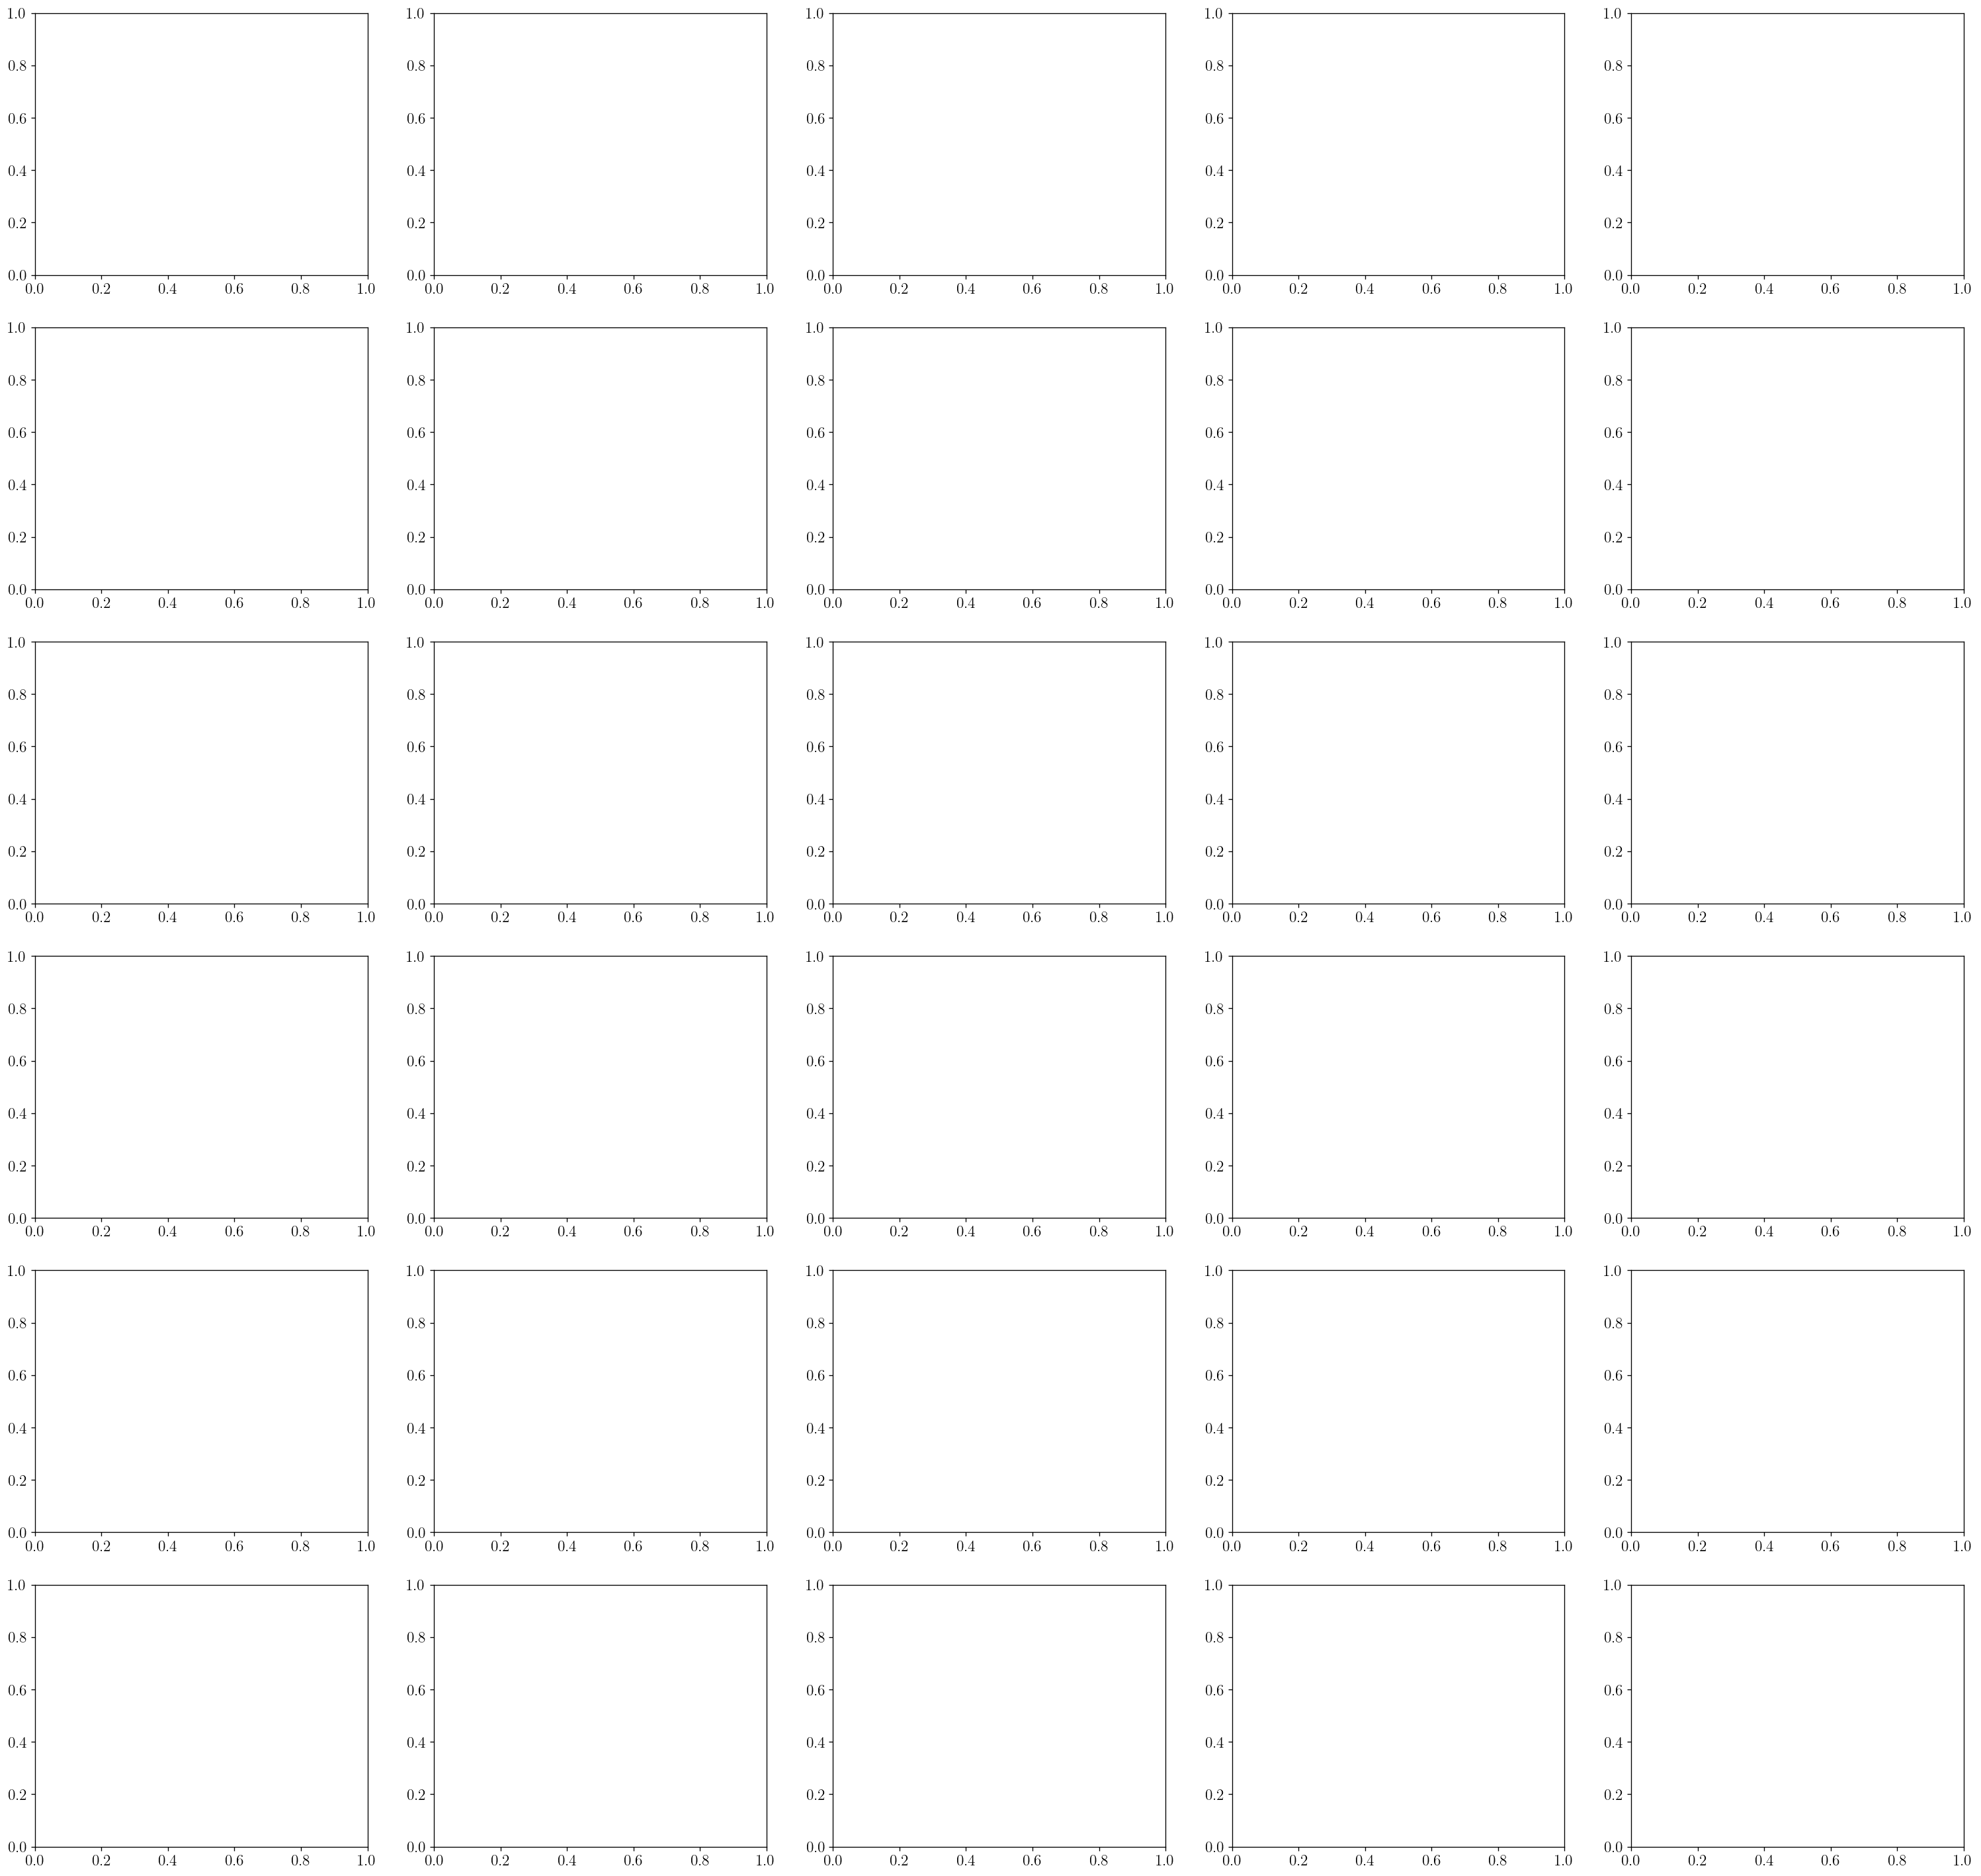

In [11]:
slice_val = 3.2  # y-value of slice

nrows = 6
ncols = 5
sub = (nrows, ncols, 1)
vmin = -1.4 ; vmax = 1.6

# highlight best models (dif_names ordered from 0 - 79)
roman_nums_arr = [ef.int_to_Roman(i) for i in range(1,80+1)]
best_models_rom = ['X', 'XV', 'XLVIII', 'XLIX', 'LIII']
model_names = ['O'] + best_models_rom
best_models = [roman_nums_arr.index(r) + 1 for r in best_models_rom]

# gridspec = {'width_ratios': [1, 1, 1, 1, 1, 0.1]}
fig, axes = plt.subplots(figsize=(6.*nrows, 6*ncols), dpi= 120, nrows = nrows, ncols = ncols)
fig.subplots_adjust(right=0.8)    
cbar_ax_list = []

for i in range(nrows):
    exp_gp_samples_cart = exp_gp_samples_cart_list[i]
    temp_sample_dict_cmask = temp_sample_dict_cmask_list[i]

    # 1d slice of GCE
    q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0) # cartesian sample map quantiles

    plt.axes(axes[i,0], aspect = 'equal')
    eplt.cart_plot_1d(q, sim_cart = None, raw_cart = None, 
        slice_dir = 'horizontal', slice_val = slice_val, 
        mask_map_cart = mask_map_cart,
        n_pixels = n_pixels,
        ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')
    sub = sub[:2] + (sub[2] + 1,)
    plt.text(0.25, 0.925, 'Model {}'.format(model_names[i]), horizontalalignment = 'center', verticalalignment = 'center', transform = axes[i,0].transAxes, fontsize = 30)

    plt.axes(axes[i,1], aspect = 'equal')
    eplt.cart_plot_1d(q, sim_cart = None, raw_cart = None, 
        slice_dir = 'vertical', slice_val = slice_val, 
        mask_map_cart = mask_map_cart,
        n_pixels = n_pixels,
        ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')
    sub = sub[:2] + (sub[2] + 1,)
    plt.text(0.25, 0.925, 'Model {}'.format(model_names[i]), horizontalalignment = 'center', verticalalignment = 'center', transform = axes[i,0].transAxes, fontsize = 30)

    # set range of vmin and vmax
    # vmin = np.round(np.log10(temp_sample_dict_cmask['gp'][1:ncols]).min(axis = 1).mean(axis = 0), 1)
    # vmax = np.round(np.log10(temp_sample_dict_cmask['gp'][1:ncols].max(axis = 1)).mean(axis = 0), 1)

    idxs = jax.random.randint(jax.random.PRNGKey(53), (nrows, ncols - 1), 0, temp_sample_dict_cmask['gp'].shape[0])
    for j in range(2, ncols):
        idx = idxs[i,j-1] # random idx for GP sampling
        m = ef.convert_masked_array_to_hp_array(temp_sample_dict_cmask['gp'][idx], mask, log_option = True, nside = 128)
        plt.axes(axes[i,j])
        eplt.inner_roi_map(m, title = None, vmin = vmin, vmax = vmax, subplot = sub, 
            display_y_info = False if j != 1 else True,
            display_x_info = False if i != nrows - 1 else True,
            cbar = False,
            xsize = xsize)
        sub = sub[:2] + (sub[2] + 1,)

    # setup the normalization and the colormap
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colormap = mpl.cm.viridis

    # setup the colorbar
    scalarmappaple = mpl.cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(np.linspace(vmin,vmax,100))
    cbar_ax_list.append(fig.add_axes([0.995, 0.02 + 0.98 * i / 5, 0.01, 0.175 * 5/6]))  # left, bottom, width, height, note we need to offset the bottom of the colorbar to shift up
    fig.colorbar(scalarmappaple, cax=cbar_ax_list[i])

for i in range(nrows):
    for j in range(ncols):
        if i != nrows - 1:
            axes[i,j].set_xlabel(None)

plt.tight_layout()
# fig.savefig('figures/fig_fit_to_data_gp_samples.pdf', bbox_inches='tight')

IndexError: index 5 is out of bounds for axis 1 with size 5

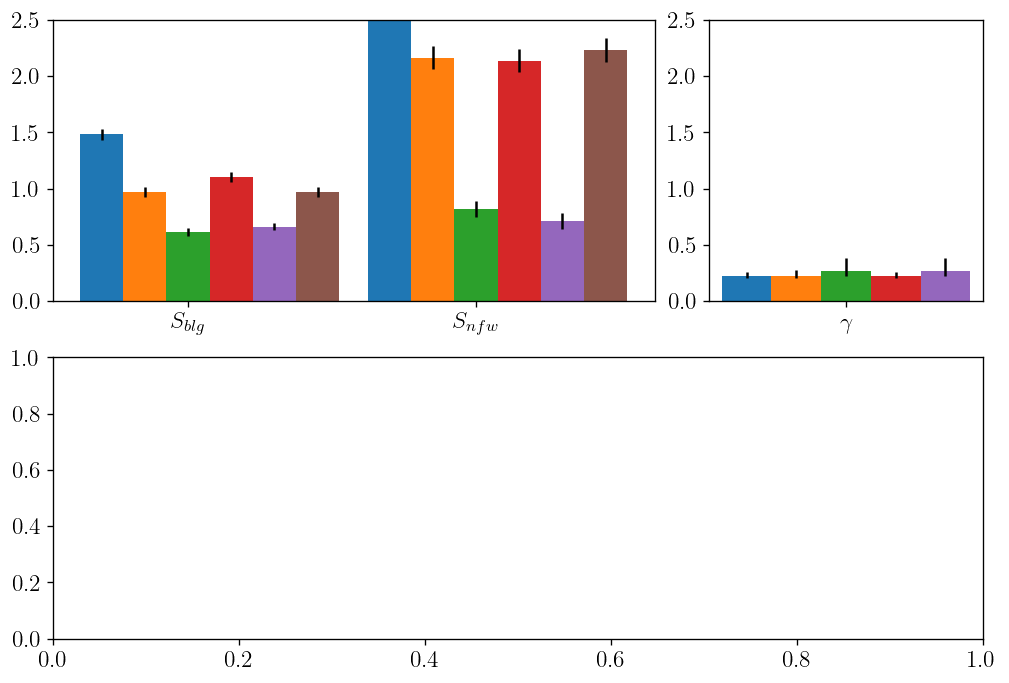

In [42]:
# histogram plots of bulges

# blg id and blg name
blg_id = np.arange(1,6)
blg_names = [ef.gen_blg_name_(int(blg_id[j]) - 1)[0] for j in range(len(blg_id))]

# highlight best models (dif_names ordered from 0 - 79)
roman_nums_arr = [ef.int_to_Roman(i) for i in range(1,80+1)]
best_models_rom = ['X', 'XV', 'XLVIII', 'XLIX', 'LIII']
model_names = ['O'] + best_models_rom
best_models = [roman_nums_arr.index(r) + 1 for r in best_models_rom]

from scipy.special import softmax
fig = plt.figure(figsize=(10,14), dpi= 120)

ax11 = plt.subplot2grid((4, 3), (0, 0), colspan = 2)
num_trials = 6
width = 0.15

rects = []
colors = ['C' + str(i) for i in range(6)]
for n in range(num_trials):
    t = np.linspace(0,1,2)
    ind = np.arange(len(t))

    temp_samples = temp_samples_list[n]
    q_blg = np.quantile(temp_samples['S_blg'], [0.16, 0.5, 0.84])
    q_nfw = np.quantile(temp_samples['S_nfw'], [0.16, 0.5, 0.84])

    rel_norms = np.array([q_blg[1], q_nfw[1]])
    yerr = np.array([[q_blg[1] - q_blg[0], q_nfw[1] - q_nfw[0]], [q_blg[2] - q_blg[1], q_nfw[2] - q_nfw[1]]])

    rects.append(ax11.bar(ind - 2. * width + n * width , rel_norms, width, yerr = yerr, 
                        color = colors[n], label = 'Dif Model {}'.format(n)))

ax11.set_ylim(0, 2.5)
ax11.set_xticks(ind)
ax11.set_xticklabels(['$S_{blg}$', '$S_{nfw}$'])
# ax11.text(0.9, 2., 'Normalizations', fontsize=20, ha='center')

ax12 = plt.subplot2grid((4, 3), (0, 2), colspan = 1)
num_trials = 5
width = 0.15

rects = []
colors = ['C' + str(i) for i in range(5)]
for n in range(num_trials):
    t = np.linspace(0,1,1)
    ind = np.arange(len(t))

    temp_samples = temp_samples_list[n]
    if 'gamma' not in list(temp_samples.keys()):
        q_gamma = np.quantile(np.zeros_like(temp_samples['S_nfw']), [0.16, 0.5, 0.84])
    else:
        q_gamma = np.quantile(temp_samples['gamma'], [0.16, 0.5, 0.84])

    rel_norms = np.array([q_gamma[1]])
    yerr = np.array([[q_gamma[1] - q_gamma[0]], [q_gamma[2] - q_gamma[1]]])

    rects.append(ax12.bar(ind - 2. * width + n * width , rel_norms, width, yerr = yerr, 
                        color = colors[n], label = 'Dif Model {}'.format(n)))

ax12.set_ylim(0, 2.5)
ax12.set_xticks(ind)
ax12.set_xticklabels(['$\\gamma$'])
# ax12.text(0, 1.75, 'NFW Gamma', fontsize=20, ha='center')

ax2 = plt.subplot2grid((4, 3), (1, 0), colspan = 3)
num_trials = 6
width = 0.15

rects = []
colors = ['C' + str(i) for i in range(5)]
for n in range(num_trials):
    t = np.linspace(0,1,6)
    ind = np.arange(len(t))

    temp_samples = temp_samples_list[n]
    q_rel = np.quantile(temp_samples['theta_blg'], [0.16, 0.5, 0.84], axis = 0)

    rel_norms = [q_rel[1,i] for i in range(6)]
    yerr = [[q_rel[1,i] - q_rel[0,i] for i in range(6)], [q_rel[2,i] - q_rel[1,i] for i in range(6)]]

    rects.append(ax2.bar(ind - 2. * width + n * width , rel_norms, width, yerr = yerr, 
                        color = colors[n], label = 'Model {}'.format(model_names[n])))

ax2.set_xlabel('Relative Normalizations ($\\theta$)')
ax2.set_xticks(ind)
ax2.set_xticklabels(blg_names)
ax2.legend()
# ax2.text(0.55, 0.75, 'Bulge Comparisons', fontsize=24, ha='center')

plt.tight_layout(pad = 0.5)
# fig.savefig('figures/fig_fit_to_data_bulge_comparisons.pdf', bbox_inches='tight')

In [139]:
# load GPU
gpu_id = '0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# name of the synthetic directory
sim_name = 'fit_to_data'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 99999
svi_id = 42 # (24,25) =  (no outer roi, outer roi)
sim_seed = -1
svi_seed = 0

# load data directory
data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)
# import all saved model parameters from python file
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    settings_7p1234567_5p23457_1p16_-1_99999_42_-1_0.py
    ebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
    __init__.py
    summary.txt
    ebin10_smp_svi_res_0.1_20000_mvn_8_-1_0.p
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_99999_42_-1_0.cpython-311.pyc


In [140]:
# load saved data from GP -> Data fit
fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

samples_dict, svi_results = pickle.load(open(fit_dir + fit_file_name, 'rb'))

# generate temp_sample_dict
all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'nfw', 'dsk', 'gp']
names = list(samples_dict.keys())
temp_sample_dict = {k: samples_dict[k] for k in all_temp_names if k in names}
temp_sample_dict_cmask = {k: samples_dict[k + '_cmask'] for k in all_temp_names if k in names}

/tmp/ipykernel_1554149/2245513804.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


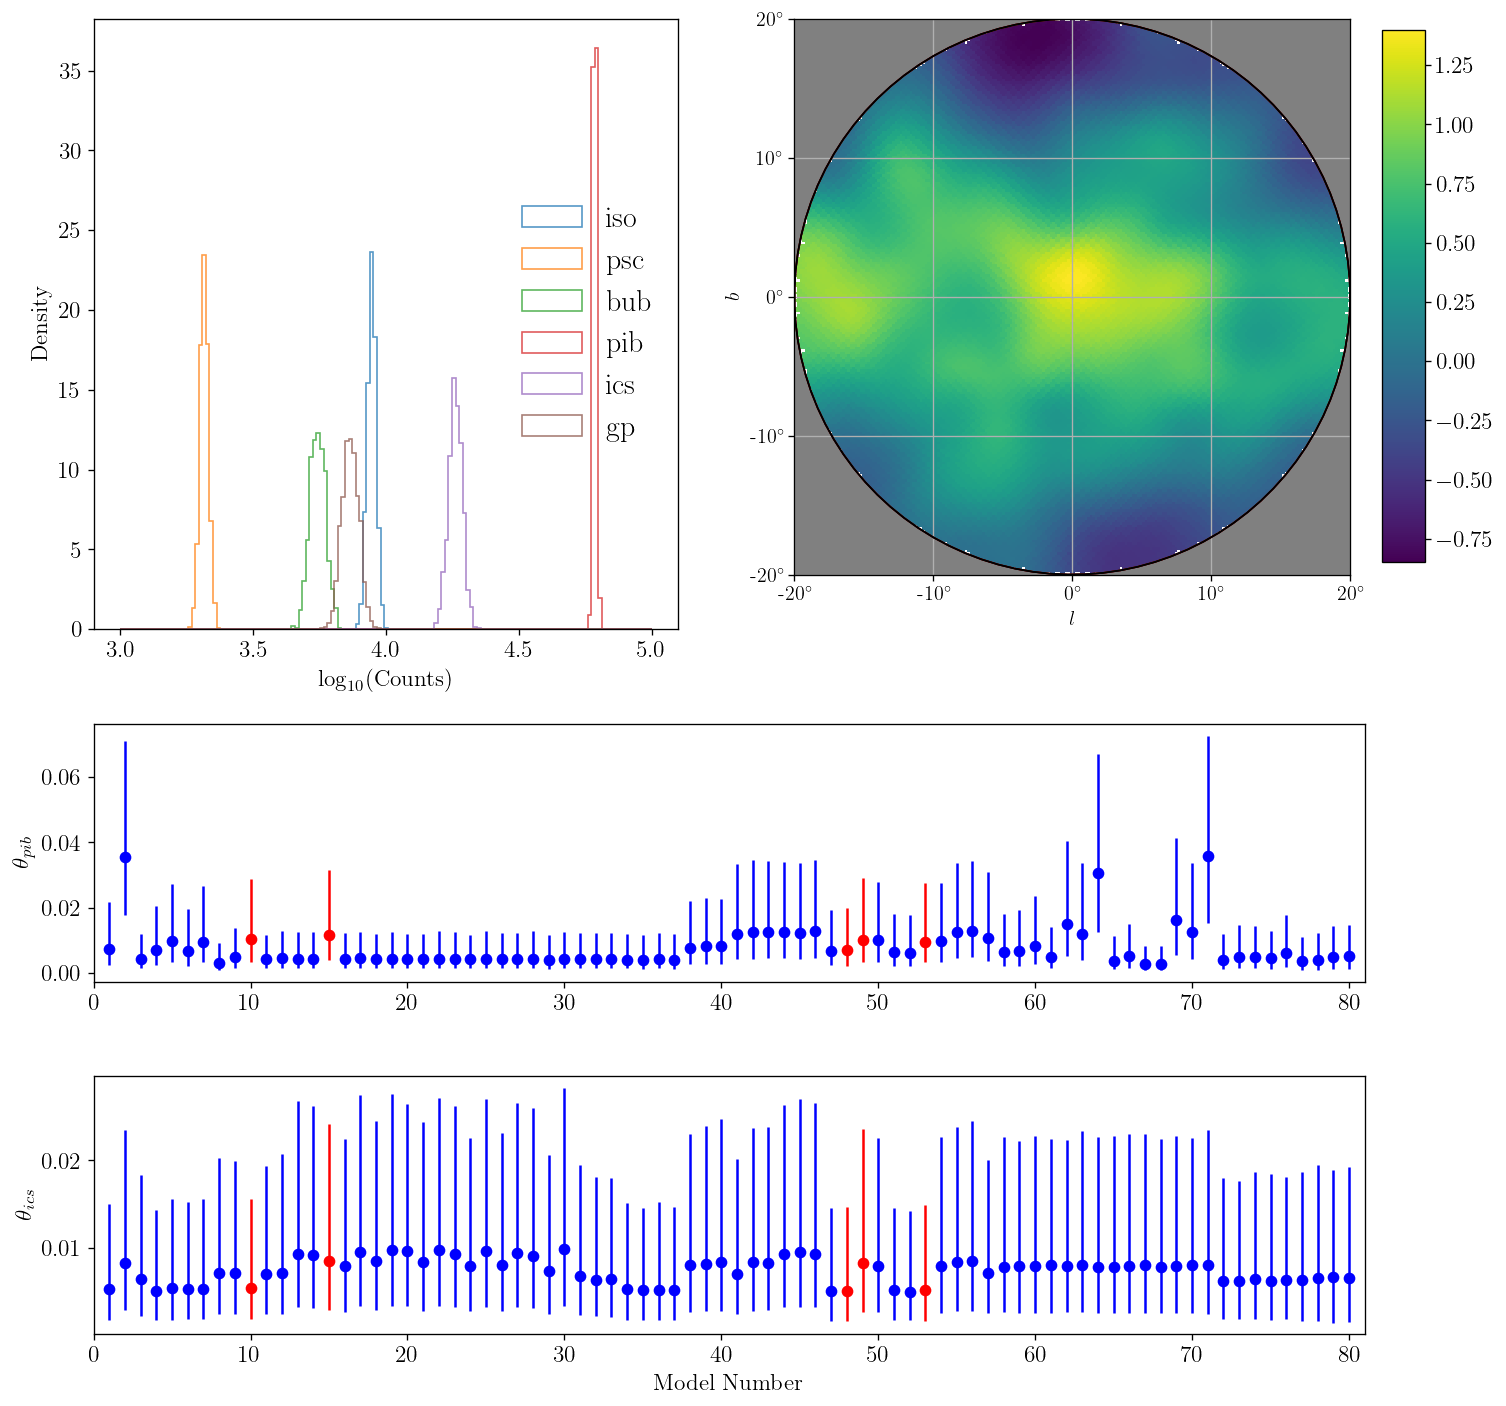

In [141]:
vmin = -0.85 ; vmax = 1.4

fig = plt.figure(figsize=(12,12), dpi= 120)

ax11 = plt.subplot2grid((4, 2), (0, 0), rowspan = 2)
ax12 = plt.subplot2grid((4, 2), (0, 1), rowspan = 2)
ax2 = plt.subplot2grid((4, 2), (2, 0), colspan = 2)
ax3 = plt.subplot2grid((4, 2), (3, 0), colspan = 2)

plt.axes(ax11)
mask_p = ebinmodel.mask_roi_arr[ebin]
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
if data_file != 'fermi_data_sum':
    ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = ax11)
else:
    ef.tot_log_counts_hist(temp_sample_dict, None, None, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = ax11)

temp_sample_dict_cmask = temp_sample_dict_cmask_list[i]
q = np.percentile(temp_sample_dict_cmask['gp'], 50, axis = 0)
m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
plt.axes(ax12)
eplt.inner_roi_map(m, title = None, vmin = vmin, vmax = vmax, subplot = 222, cbar = False)

# setup the normalization and the colormap
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
colormap = mpl.cm.viridis

# setup the colorbar
scalarmappaple = mpl.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(np.linspace(vmin,vmax,100))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.98, 0.6, 0.03, 0.37])  # left, bottom, width, height
fig.colorbar(scalarmappaple, cax=cbar_ax)

plt.axes(ax2)
q = np.quantile(samples_dict['theta_pib'], [0.16, 0.5, 0.84], axis = 0)
eplt.rel_norm_comparisons_all(q)
plt.ylabel('$\\theta_{pib}$')
plt.xlim(0, 81)

plt.axes(ax3)
q = np.quantile(samples_dict['theta_ics'], [0.16, 0.5, 0.84], axis = 0)
eplt.rel_norm_comparisons_all(q)
plt.xlabel('Model Number')
plt.ylabel('$\\theta_{ics}$')
plt.xlim(0, 81)

plt.tight_layout()
fig.savefig('figures/fig_fit_to_data_all_models.pdf', bbox_inches='tight')